# This notebook does the 2-point and 3-point fits simultaneously

In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [34]:
import pickle

In [35]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [36]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [37]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")


In [38]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and sum-subtracted samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

<ipython-input-38-2f60309b0160>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-38-2f60309b0160>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-38-2f60309b0160>:17: RuntimeWarning: invalid value enco

In [39]:
np.shape(gv_avg_data['FH'])

(64, 4)

#### Define functions

In [40]:
def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

#def param_FHdata(p):
    #sub_p = gv.BufferDict()
    #sub_p['E0'] = p['E0']
    #sub_p['Z0'] = p['Z0']
    #sub_p['Ztilde0'] = p['Ztilde0']
    
    #for k in range(1, num_states_FHdata - 1):
        #sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        #sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        #sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    #sub_p['Z{}'.format(num_states_FHdata - 1)] = p['Z_FHdatamax']
    #sub_p['Ztilde{}'.format(num_states_FHdata - 1)] = p['Ztilde_FHdatamax']
    #sub_p['log(dE{})'.format(num_states_FHdata - 1)] = p['log(FHdata_dEmax)']
    
    #for n in range(num_states_FHdata-1):
        #for m in range(num_states_FHdata-1):
                
            #sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            #sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    #for n in range(num_states_FHdata-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FHdata-1)] = p['gA3_{}FHdatamax'.format(n)]
        #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, n)] = p['gA3_FHdatamax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FHdata-1)] = p['gV4_{}FHdatamax'.format(n)]
        #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, n)] = p['gV4_FHdatamax{}'.format(n)]
        
    #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gA3_FHdatamaxFHdatamax']
    #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gV4_FHdatamaxFHdatamax']
    
    #for n in range(num_states_FHdata):
        #sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        #sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        #sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        #sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    #return sub_p

In [41]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [42]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [43]:
num_states_FH = 1 # The number of states that the Feynman-Hellman and sum-subtraction uses

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0s
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [44]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

#def C_FHdata_A3_ss(t, p):
    #return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_A3_ps(t, p):
    #return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))


#def C_FHdata_V4_ss(t, p):  
    #return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_V4_ps(t, p):
    #return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #, axes=[2,0,1]

In [45]:
# Gets a single 2-element, passes it to C_2pt if it's of the form [None, tau], C_3pt if it's of the form [tsep, tau], C_FH if it's of the form [tsep, None]
def single_choice(t_sel, p):
    if t_sel[0] is None:
        return C_2pt(np.array([t_sel[1]]), p)
    
    else:
        if t_sel[1] is None:
            FH_t_sel_res = C_FH(np.array([t_sel[0]]), p)
            return np.array([[[FH_t_sel_res[0][0]], [FH_t_sel_res[0][1]]]])
        
        elif t_sel[1] == -1: ## t_sel[1] == -1 is the condition for the A3 Feynman-Hellman data function
            FHdata_t_sel_res = C_FHdata(np.array([t_sel[0]]), p)
            return np.array([[[FHdata_t_sel_res[0][0]], [FHdata_t_sel_res[0][1]]]])
        
        elif t_sel[1] == -2: ## t_sel[1] == -2 is the condition for the V4 Feynman-Hellman data function
            FHdata_t_sel_res = C_FHdata(np.array([t_sel[0]]), p)
            return np.array([[[FHdata_t_sel_res[0][2]], [FHdata_t_sel_res[0][3]]]])
        
        else:
            return np.array([C_3pt(np.array([[t_sel[0], t_sel[1]]]), p)])[0]
        
def all_at_once(t, p):
    
    #if np.shape(t) == (2,):
        #return single_choice(t, p)
    
    #else:
        #for t_sel in t:
            #print("Shape of t_sel: ", np.shape(t_sel))
    return [single_choice(t_sel, p)[0] for t_sel in t]
    #t_2pt = t[0]
    #t_3pt = t[1]
    #t_CFH = t[2]
    #return np.array([C_2pt_SS(t_2pt, p), C_2pt_PS(t_2pt, p), C_3pt_A3(t_3pt, p), C_3pt_V4(t_3pt, p), C_FH_A3(t_CFH, p), C_FH_V4(t_CFH, p)]) #np.transpose(
    
    
# Like all_at_once, but uses dictionaries
def all_at_once_dict(t, p):
    out = gv.BufferDict()
    if '2pt' in t.keys():
        out['2pt'] = C_2pt(t['2pt'], p)
    if '3pt' in t.keys():
        out['3pt_combined'] = C_3pt(t['3pt'], p)
    if 'sum_sub' in t.keys():
        out['C^FH_combined'] = C_FH(t['sum_sub'], p)
    if 'FH' in t.keys():
        out['FH'] = C_FHdata(t['FH'], p)
    
    return out

In [46]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d

<ipython-input-46-e0790b6350f7>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])


#### Do the fits

In [47]:
num_zs = 7

# prior the fits
prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior['E0'] = gv.gvar(0.66, 0.01)
prior['Z0'] = gv.gvar(0.0008, 0.00008)
prior['Ztilde0'] = gv.gvar(0.003, 0.001)


# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.9

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.66, 0.01)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

prior['Z1'] = gv.gvar(0.0005, 0.0005)
prior['Ztilde1'] = gv.gvar(0.003, 0.003)
prior['Z2'] = gv.gvar(0.0005, 0.0005)
prior['Ztilde2'] = gv.gvar(0.003, 0.003)
    
for n in range(1, num_zs):
    prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    if n > 2:
        prior['Z{}'.format(n)] = gv.gvar(0.0004, 0.0004)
        prior['Ztilde{}'.format(n)] = gv.gvar(0.002, 0.002)

#print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 1)
        if n == m and n < num_zs-1:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.2)
        else:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 1)

prior['gA3_00'] = gv.gvar(1.25, 0.15)
prior['gV4_00'] = gv.gvar(1.07, 0.07)


In [48]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all

#print(np.shape(y_all_dict['3pt_combined']))


fit_simul = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul = fit_simul.p

<ipython-input-48-e5f134a9ec8d>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-48-e5f134a9ec8d>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 0.91 [150]    Q = 0.78    logGBF = 3817.9

Parameters:
             E0       0.661805 +- 0.00281014             [     0.66 +- 0.01 ]  
             Z0   0.000757262 +- 1.11787e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00285786 +- 4.92639e-05             [   0.003 +- 0.001 ]  
             Z1   0.000519435 +- 8.80574e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00341873 +- 0.000630279             [   0.003 +- 0.003 ]  
             Z2   0.000871873 +- 0.000145314             [ 0.0005 +- 0.0005 ]  
        Ztilde2     0.00722671 +- 0.00106866             [   0.003 +- 0.003 ]  *
       log(dE1)        -0.993722 +- 0.163752             [  -0.97551 +- 0.9 ]  
       log(dE2)         -0.619459 +- 0.13628             [  -0.97551 +- 0.9 ]  
       log(dE3)         -1.10953 +- 0.644516             [  -0.97551 +- 0.9 ]  
             Z3   0.000715544 +- 0.000234446             [ 0.0004 +- 0.0004 ]  
        Ztilde3     0.00369

In [49]:
current_posterior = open('simul2pt3pt_n5_out.obj', 'wb')
pickle.dump(post_simul, current_posterior)
current_posterior.close() #n=6: 3791

### Now, plot the data against the fit

In [50]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-50-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-50-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-50-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [51]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

#CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
#CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
#CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
#CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
#CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
#CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

<ipython-input-51-01b164071101>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-51-01b164071101>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-51-01b164071101>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

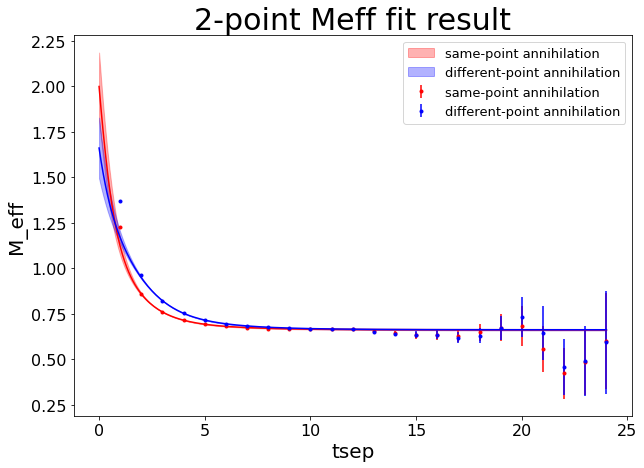

<Figure size 432x288 with 0 Axes>

In [52]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

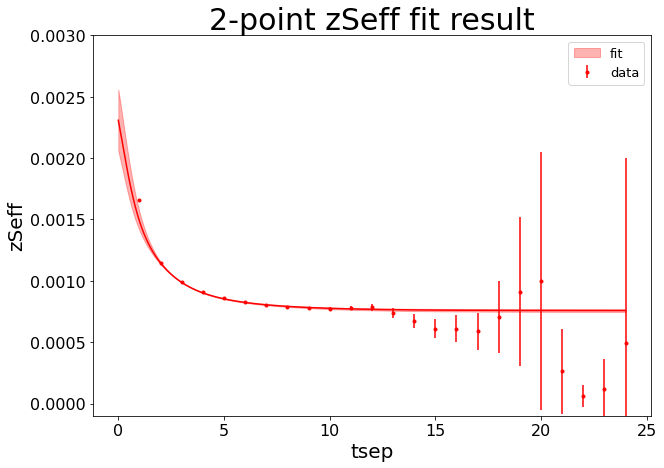

<Figure size 432x288 with 0 Axes>

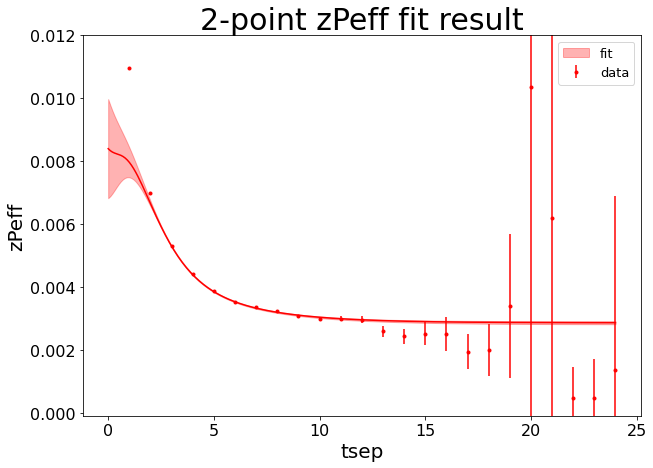

<Figure size 432x288 with 0 Axes>

In [53]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

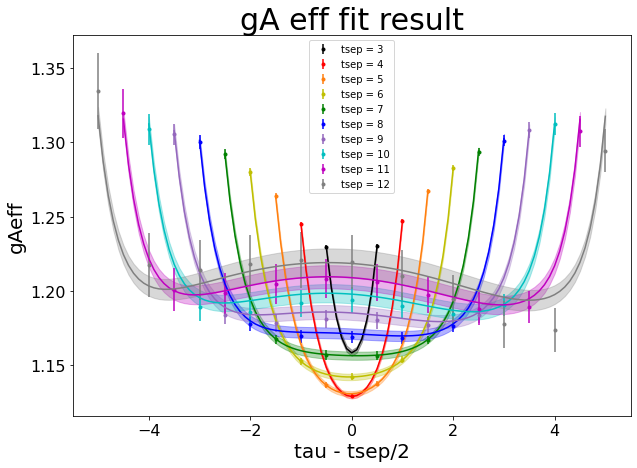

<Figure size 432x288 with 0 Axes>

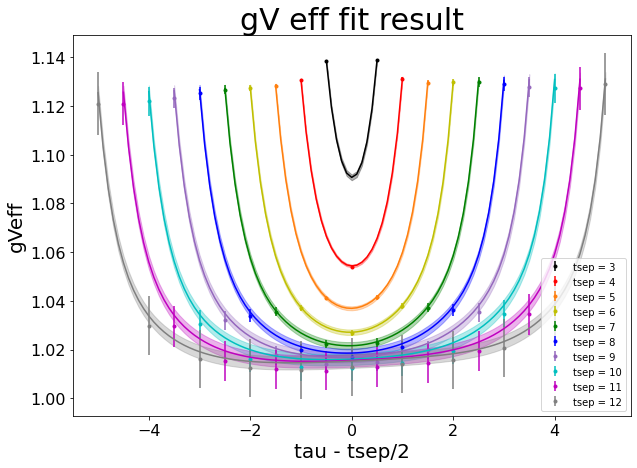

<Figure size 432x288 with 0 Axes>

In [54]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



#### Now, try the same, but with the 3-point data cut off at tau = 2

In [55]:
num_zs = 4
tau_cut_val = 2

x_2pt = np.array([l for l in range(3, 13)])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)


y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

x_all_tau2 = np.append(x_2pt_mod, x_1darray_tau2) 
y_all_tau2 = np.append(y_2pt_all, y_3pt_tau2)

x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_1darray_tau2

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_tau2


fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul_tau2.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p

<ipython-input-55-d3eebb14bf85>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-55-d3eebb14bf85>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 0.96 [110]    Q = 0.61    logGBF = 2808.6

Parameters:
             E0       0.656491 +- 0.00544813             [     0.66 +- 0.01 ]  
             Z0   0.000719345 +- 3.50168e-05             [  0.0008 +- 8e-05 ]  *
        Ztilde0    0.00267632 +- 0.000151092             [   0.003 +- 0.001 ]  
             Z1   0.000392798 +- 8.02991e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.0019796 +- 0.00030029             [   0.003 +- 0.003 ]  
             Z2   0.000519035 +- 0.000138822             [ 0.0005 +- 0.0005 ]  
        Ztilde2    0.00491489 +- 0.000897786             [   0.003 +- 0.003 ]  
       log(dE1)         -1.86415 +- 0.396107             [  -0.97551 +- 0.9 ]  
       log(dE2)         -0.771595 +- 0.20467             [  -0.97551 +- 0.9 ]  
       log(dE3)         -1.02052 +- 0.328919             [  -0.97551 +- 0.9 ]  
             Z3    0.00105329 +- 7.98464e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde3    0.00660

In [56]:
current_posterior = open('simul2pt3pt_tau2_n4_out.obj', 'wb')
pickle.dump(post_simul_tau2, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [57]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-57-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-57-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-57-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [58]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul_tau2)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul_tau2)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul_tau2)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul_tau2post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])



<ipython-input-58-c7d185f82f5e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-58-c7d185f82f5e>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-58-c7d185f82f5e>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

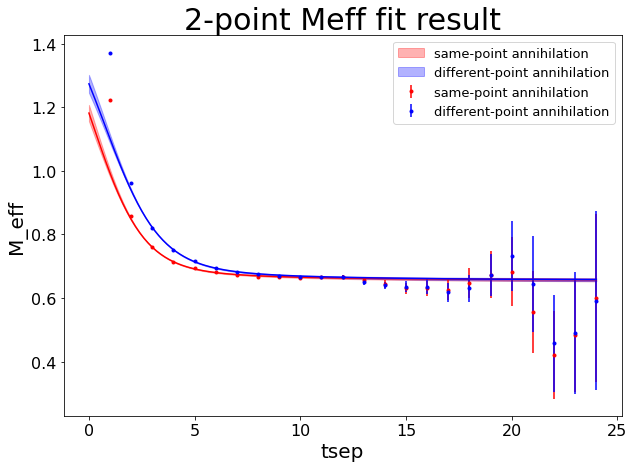

<Figure size 432x288 with 0 Axes>

In [59]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

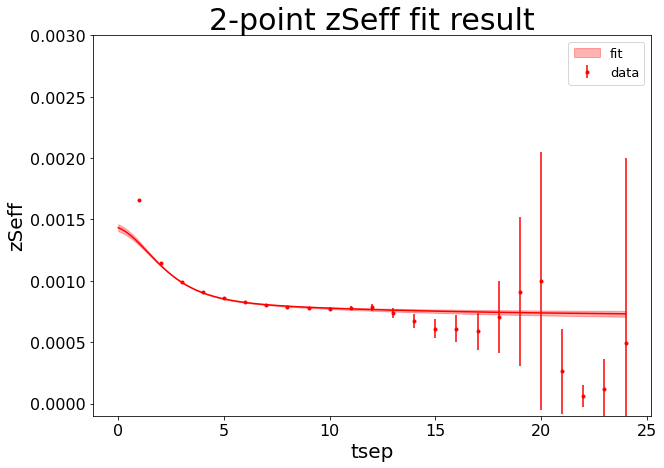

<Figure size 432x288 with 0 Axes>

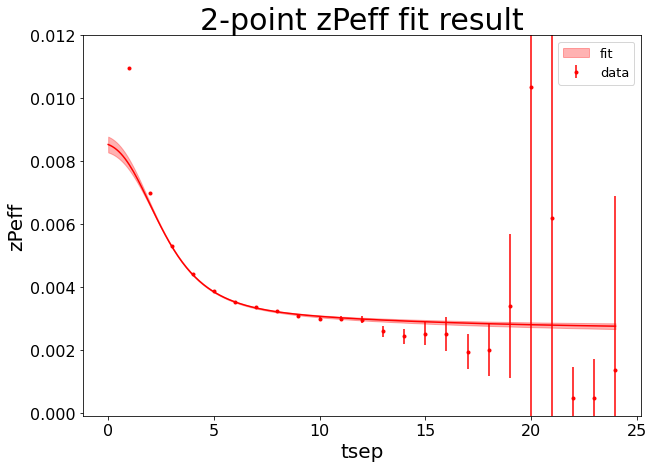

<Figure size 432x288 with 0 Axes>

In [60]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

[list([-0.5, 0.5]) list([-1.0, 0.0, 1.0]) list([-1.5, -0.5, 0.5, 1.5])
 list([-2.0, -1.0, 0.0, 1.0, 2.0]) list([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
 list([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
 list([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])
 list([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])
 list([-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
 list([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])]
[array([1.22948653, 1.23043176])
 array([1.24511272, 1.12911504, 1.24715104])
 array([1.26408926, 1.13658814, 1.13750236, 1.26702087])
 array([1.28008458, 1.15262906, 1.1422122 , 1.15371275, 1.28268815])
 array([1.29225314, 1.16738478, 1.15676178, 1.15649022, 1.16701901,
       1.29341666])
 array([1.30047282, 1.17765951, 1.16929791, 1.16885643, 1.16799239,
       1.17608424, 1.30111217])
 array([1.3053317 , 1.18410074, 1.17839337, 1.18089024, 1.18009565,
       1.17684057, 1.18371736, 1.30850508])
 array([1.308739  , 1.18898057, 1.18585296, 1.1915555 , 1.19360

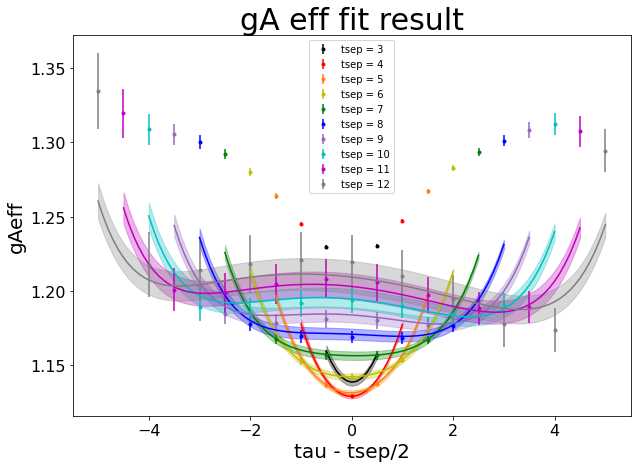

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

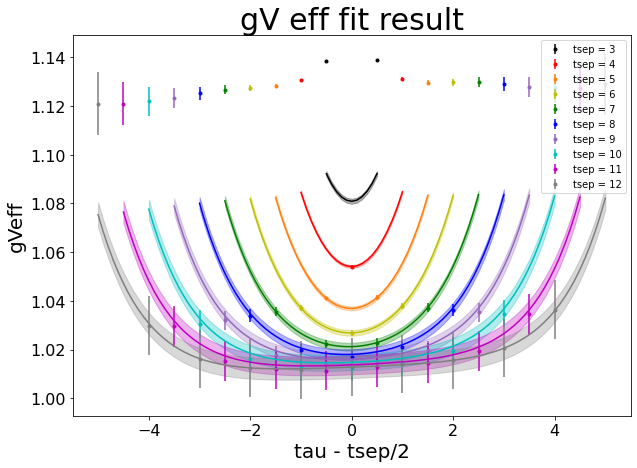

<Figure size 432x288 with 0 Axes>

In [61]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
print(x_3pt_data)
print(y_3pt_A3)

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


 


### Now, include the fit to the Feynman-Hellman data in the chained fit

In [62]:
num_zs = 7
num_states_FH = 2

# prior the fits
prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior['E0'] = gv.gvar(0.66, 0.01)
prior['Z0'] = gv.gvar(0.0008, 0.00008)
prior['Ztilde0'] = gv.gvar(0.003, 0.001)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.66, 0.01)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

prior['Z1'] = gv.gvar(0.0005, 0.0005)
prior['Ztilde1'] = gv.gvar(0.003, 0.003)
prior['Z2'] = gv.gvar(0.0005, 0.0005)
prior['Ztilde2'] = gv.gvar(0.003, 0.003)
    
for n in range(1, num_zs):
    prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    if n > 2:
        prior['Z{}'.format(n)] = gv.gvar(0.0004, 0.0004)
        prior['Ztilde{}'.format(n)] = gv.gvar(0.002, 0.002)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior["d_gA_ss_{}".format(n)] = gv.gvar(-0.0000015, 0.0000015)
    prior["d_gA_ps_{}".format(n)] = gv.gvar(-0.000009, 0.000009)
    prior["d_gV_ss_{}".format(n)] = gv.gvar(0.0000013, 0.0000013)
    prior["d_gV_ps_{}".format(n)] = gv.gvar(0.0000075, 0.0000075)
    for m in range(num_zs):
        
        prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 1)
        if n == m and n < num_zs-1:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.2)
        else:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 1)

prior['gA3_00'] = gv.gvar(1.25, 0.15)
prior['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
if num_states_FH > 2:
    prior['Z_FHmax'] = gv.gvar(0.0005, 0.0005)
    prior['Ztilde_FHmax'] = gv.gvar(0.003, 0.003)
        
else:
    prior['Z_FHmax'] = gv.gvar(0.0004, 0.0004)
    prior['Ztilde_FHmax'] = gv.gvar(0.002, 0.002)

if num_states_FH > 1:
    prior['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH-2]), b)

for n in range(num_states_FH-1):
    prior['gA3_FHmax{}'.format(n)] = gv.gvar(0, 1)
    prior['gA3_{}FHmax'.format(n)] = gv.gvar(0, 1)
    prior['gV4_FHmax{}'.format(n)] = gv.gvar(0, 1)
    prior['gV4_{}FHmax'.format(n)] = gv.gvar(0, 1)
    
prior['gA3_FHmaxFHmax'] = gv.gvar(0, 1)
prior['gV4_FHmaxFHmax'] = gv.gvar(1, 0.2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)

#prior

0


In [63]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt
x_all_dict['FH'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all
y_all_dict['FH'] = gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

fit_simul = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul = fit_simul.p
# chi2/dof [dof] = 0.85 [186]    Q = 0.94    logGBF = 3892.8
# chi2/dof [dof] = 0.83 [186]    Q = 0.96    logGBF = 3868.1
# chi2/dof [dof] = 0.8 [186]    Q = 0.98    logGBF = 3879.4

<ipython-input-63-bdfe00743b5f>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-63-bdfe00743b5f>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 1.2e+03 [186]    Q = 0    logGBF = -1.0968e+05

Parameters:
             E0        0.660003 +- 0.00977799             [        0.66 +- 0.01 ]  
             Z0    2.48156e-05 +- 9.28051e-06             [     0.0008 +- 8e-05 ]  *****
        Ztilde0      0.00291523 +- 0.00092512             [      0.003 +- 0.001 ]  
             Z1     0.000190406 +- 0.00010287             [    0.0005 +- 0.0005 ]  
        Ztilde1      0.00298528 +- 0.00118177             [      0.003 +- 0.003 ]  
             Z2    0.000290737 +- 0.000142518             [    0.0005 +- 0.0005 ]  
        Ztilde2      0.00299534 +- 0.00142346             [      0.003 +- 0.003 ]  
       log(dE1)          -0.97551 +- 0.308281             [     -0.97551 +- 0.7 ]  
       log(dE2)          -0.97551 +- 0.587395             [     -0.97551 +- 0.7 ]  
       log(dE3)          -0.97551 +- 0.662046             [     -0.97551 +- 0.7 ]  
             Z3    0.000213977 +- 0.000325386             

In [64]:
current_posterior = open('simul2pt3pt_n5_withFH_out.obj', 'wb')
pickle.dump(post_simul, current_posterior)
current_posterior.close() #n=6: 3791

#### Now, try the same, but with the 3-point data cut off at tau = 2

In [65]:
num_zs = 4
tau_cut_val = 3

# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt_all[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_1darray_tau2
x_all_dict['FH'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_tau2
y_all_dict['FH'] = gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p


fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul_tau2.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p

<ipython-input-65-21d9589bf2ff>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-65-21d9589bf2ff>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Least Square Fit:
  chi2/dof [dof] = 1.2e+03 [186]    Q = 0    logGBF = -1.0968e+05

Parameters:
             E0        0.660003 +- 0.00977799             [        0.66 +- 0.01 ]  
             Z0    2.48156e-05 +- 9.28051e-06             [     0.0008 +- 8e-05 ]  *****
        Ztilde0      0.00291523 +- 0.00092512             [      0.003 +- 0.001 ]  
             Z1     0.000190406 +- 0.00010287             [    0.0005 +- 0.0005 ]  
        Ztilde1      0.00298528 +- 0.00118177             [      0.003 +- 0.003 ]  
             Z2    0.000290737 +- 0.000142518             [    0.0005 +- 0.0005 ]  
        Ztilde2      0.00299534 +- 0.00142346             [      0.003 +- 0.003 ]  
       log(dE1)          -0.97551 +- 0.308281             [     -0.97551 +- 0.7 ]  
       log(dE2)          -0.97551 +- 0.587395             [     -0.97551 +- 0.7 ]  
       log(dE3)          -0.97551 +- 0.662046             [     -0.97551 +- 0.7 ]  
             Z3    0.000213977 +- 0.000325386             

Least Square Fit:
  chi2/dof [dof] = 0.86 [112]    Q = 0.86    logGBF = 2074.9

Parameters:
             E0        0.660225 +- 0.00285663             [        0.66 +- 0.01 ]  
             Z0    0.000751769 +- 1.15509e-05             [     0.0008 +- 8e-05 ]  
        Ztilde0     0.00283427 +- 5.01422e-05             [      0.003 +- 0.001 ]  
             Z1    0.000549897 +- 7.05162e-05             [    0.0005 +- 0.0005 ]  
        Ztilde1     0.00351173 +- 0.000535815             [      0.003 +- 0.003 ]  
             Z2    0.000899157 +- 0.000159654             [    0.0005 +- 0.0005 ]  
        Ztilde2      0.00783702 +- 0.00108768             [      0.003 +- 0.003 ]  *
       log(dE1)         -0.998986 +- 0.139506             [     -0.97551 +- 0.7 ]  
       log(dE2)         -0.541593 +- 0.121359             [     -0.97551 +- 0.7 ]  
       log(dE3)         -0.936272 +- 0.598259             [     -0.97551 +- 0.7 ]  
             Z3    0.000830558 +- 0.000235879             [    0.00

In [66]:
current_posterior = open('simul2pt3pt_tau2_withFH_n4_out.obj', 'wb')
pickle.dump(post_simul_tau2, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [67]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

<ipython-input-67-ca6fa604b8e7>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-67-ca6fa604b8e7>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-67-ca6fa604b8e7>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

In [68]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul_tau2)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul_tau2)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul_tau2)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul_tau2post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])



<ipython-input-68-c7d185f82f5e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-68-c7d185f82f5e>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
<ipython-input-68-c7d185f82f5e>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

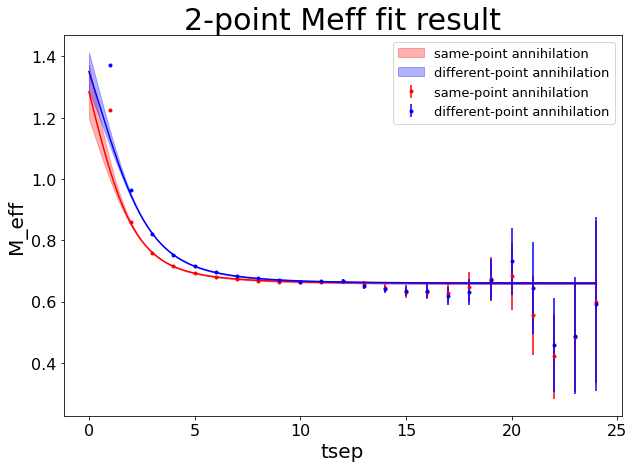

<Figure size 432x288 with 0 Axes>

In [69]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

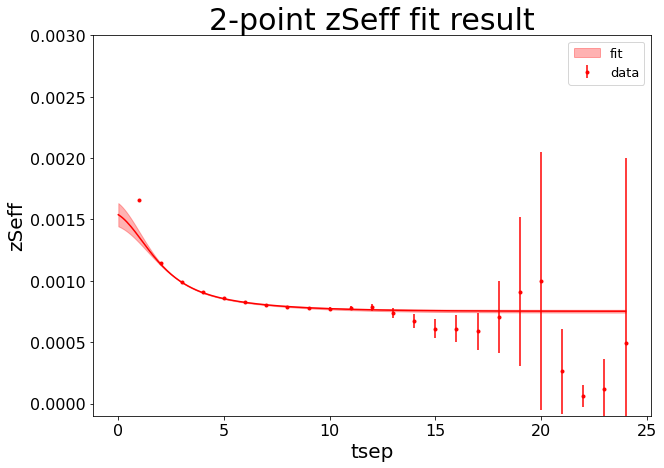

<Figure size 432x288 with 0 Axes>

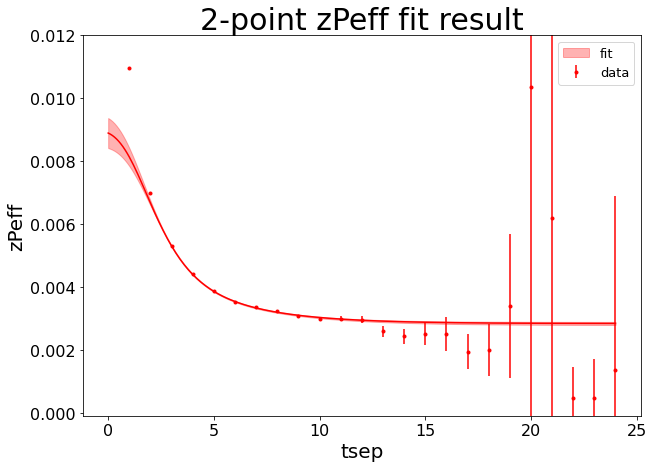

<Figure size 432x288 with 0 Axes>

In [70]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

[list([-0.5, 0.5]) list([-1.0, 0.0, 1.0]) list([-1.5, -0.5, 0.5, 1.5])
 list([-2.0, -1.0, 0.0, 1.0, 2.0]) list([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
 list([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
 list([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])
 list([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])
 list([-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
 list([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])]
[array([1.22948653, 1.23043176])
 array([1.24511272, 1.12911504, 1.24715104])
 array([1.26408926, 1.13658814, 1.13750236, 1.26702087])
 array([1.28008458, 1.15262906, 1.1422122 , 1.15371275, 1.28268815])
 array([1.29225314, 1.16738478, 1.15676178, 1.15649022, 1.16701901,
       1.29341666])
 array([1.30047282, 1.17765951, 1.16929791, 1.16885643, 1.16799239,
       1.17608424, 1.30111217])
 array([1.3053317 , 1.18410074, 1.17839337, 1.18089024, 1.18009565,
       1.17684057, 1.18371736, 1.30850508])
 array([1.308739  , 1.18898057, 1.18585296, 1.1915555 , 1.19360

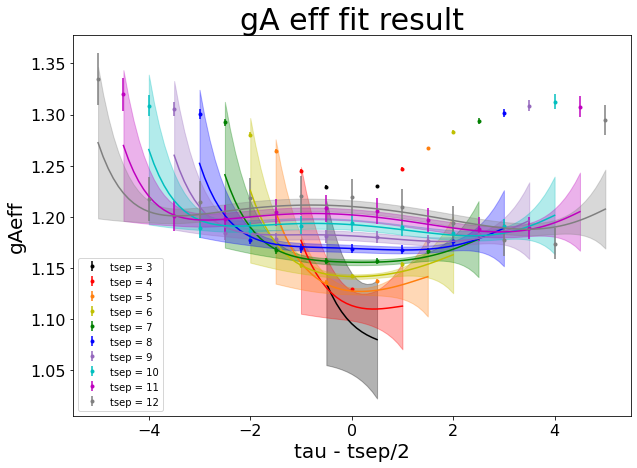

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

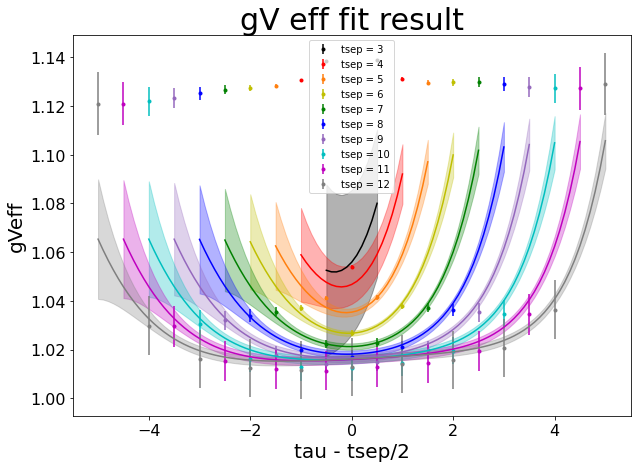

<Figure size 432x288 with 0 Axes>

In [71]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
print(x_3pt_data)
print(y_3pt_A3)

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


 


#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [72]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [73]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.66, 0.01)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.00008)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.001)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.66, 0.01)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
                
            priors[i][j][k]['Z1'] = gv.gvar(0.0005, 0.0005)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0.003, 0.003)
            priors[i][j][k]['Z2'] = gv.gvar(0.0005, 0.0005)
            priors[i][j][k]['Ztilde2'] = gv.gvar(0.003, 0.003)
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['log(dE2)'] = gv.gvar(np.log(dEvals[1]), 0.7)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0004, 0.0004)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0.002, 0.002)

            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 1)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.2)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 1)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            #priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            #if num_states_FH == 2:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            #else:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            #for n in range(num_states_FH-1):
                #priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                #priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            #priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
            #priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [74]:
list_LogGBF_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

In [75]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []
x_vals_all = []
y_vals_all = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    x_vals_all.append([])
    y_vals_all.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])
    
    x_vals_all[i] = np.append(x_2pt_mod, x_vals_3fit[i], axis = 0)
    y_vals_all[i] = np.append(y_2pt_all, y_vals_3fit[i], axis = 0)

<ipython-input-75-28236186c716>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-75-28236186c716>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


Now that the priors and the data are set, do the fits

In [45]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[0][i][k],fcn=all_at_once,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[1][i][k],fcn=all_at_once,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[2][i][k],fcn=all_at_once,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0[i][j][k] = fit_a0.logGBF
            list_Q_a0[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv'))
            list_LogGBF_a1[i][j][k] = fit_a1.logGBF
            list_Q_a1[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a1.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2[i][j][k] = fit_a2.logGBF
            list_Q_a2[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2442.9

Parameters:
             E0     0.675503 +- 0.000978543            [     0.66 +- 0.01 ]  *
             Z0   0.000798107 +- 2.3611e-06            [  0.0008 +- 8e-05 ]  
        Ztilde0   0.00310809 +- 1.12052e-05            [   0.003 +- 0.001 ]  
             Z1   0.00123102 +- 1.02308e-05            [ 0.0005 +- 0.0005 ]  *
        Ztilde1    0.00968178 +- 9.4116e-05            [   0.003 +- 0.003 ]  **
             Z2   0.00496249 +- 0.000304092            [ 0.0004 +- 0.0004 ]  *****
        Ztilde2    -0.00114147 +- 0.0019907            [   0.002 +- 0.002 ]  *
       log(dE1)    -0.0682071 +- 0.00770115            [  -0.97551 +- 0.1 ]  *****
       log(dE2)      0.885135 +- 0.00816588            [  -0.97551 +- 0.7 ]  **
         gA3_00       1.08663 +- 0.00180265            [     1.25 +- 0.15 ]  *
         gV4_00      1.00592 +- 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2442.9

Parameters:
             E0     0.675503 +- 0.000978543            [     0.66 +- 0.01 ]  *
             Z0   0.000798107 +- 2.3611e-06            [  0.0008 +- 8e-05 ]  
        Ztilde0   0.00310809 +- 1.12052e-05            [   0.003 +- 0.001 ]  
             Z1   0.00123102 +- 1.02308e-05            [ 0.0005 +- 0.0005 ]  *
        Ztilde1    0.00968178 +- 9.4116e-05            [   0.003 +- 0.003 ]  **
             Z2   0.00496249 +- 0.000304092            [ 0.0004 +- 0.0004 ]  *****
        Ztilde2    -0.00114147 +- 0.0019907            [   0.002 +- 0.002 ]  *
       log(dE1)    -0.0682071 +- 0.00770115            [  -0.97551 +- 0.1 ]  *****
       log(dE2)      0.885135 +- 0.00816588            [  -0.97551 +- 0.7 ]  **
         gA3_00       1.08663 +- 0.00180265            [     1.25 +- 0.15 ]  *
         gV4_00      1.00592 +- 

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 9e-18    logGBF = 3756.4

Parameters:
             E0       0.662772 +- 0.00191636             [     0.66 +- 0.01 ]  
             Z0    0.00076197 +- 6.44799e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00287588 +- 2.84111e-05             [   0.003 +- 0.001 ]  
             Z1   0.000555735 +- 2.97143e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00398442 +- 0.00016928             [   0.003 +- 0.003 ]  
             Z2     0.0011319 +- 2.90495e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2     0.0079629 +- 0.000262621             [   0.002 +- 0.002 ]  **
       log(dE1)        -0.89415 +- 0.0484047             [  -0.97551 +- 0.1 ]  
       log(dE2)       -0.462506 +- 0.0496669             [  -0.97551 +- 0.7 ]  
       log(dE3)           1.2785 +- 0.051021             [  -0.97551 +- 0.7 ]  ***
             Z3    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 9e-18    logGBF = 3756.4

Parameters:
             E0       0.662772 +- 0.00191636             [     0.66 +- 0.01 ]  
             Z0    0.00076197 +- 6.44799e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00287588 +- 2.84111e-05             [   0.003 +- 0.001 ]  
             Z1   0.000555735 +- 2.97143e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00398442 +- 0.00016928             [   0.003 +- 0.003 ]  
             Z2     0.0011319 +- 2.90495e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2     0.0079629 +- 0.000262621             [   0.002 +- 0.002 ]  **
       log(dE1)        -0.89415 +- 0.0484047             [  -0.97551 +- 0.1 ]  
       log(dE2)       -0.462506 +- 0.0496669             [  -0.97551 +- 0.7 ]  
       log(dE3)           1.2785 +- 0.051021             [  -0.97551 +- 0.7 ]  ***
             Z3    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.6 [150]    Q = 1.4e-05    logGBF = 3793

Parameters:
             E0        0.659788 +- 0.00197012             [     0.66 +- 0.01 ]  
             Z0     0.000751598 +- 6.5661e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0       0.0028335 +- 2.9351e-05             [   0.003 +- 0.001 ]  
             Z1    0.000685462 +- 3.09581e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00461802 +- 0.000205043             [   0.003 +- 0.003 ]  
             Z2     0.00130236 +- 6.85355e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2     0.00988466 +- 0.000838688             [   0.002 +- 0.002 ]  ***
       log(dE1)        -0.818545 +- 0.0467035             [  -0.97551 +- 0.1 ]  *
       log(dE2)        -0.125703 +- 0.0800681             [  -0.97551 +- 0.7 ]  *
       log(dE3)          0.029015 +- 0.372848             [  -0.97551 +- 0.7 ]  *
       

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.6 [150]    Q = 1.4e-05    logGBF = 3793

Parameters:
             E0        0.659788 +- 0.00197012             [     0.66 +- 0.01 ]  
             Z0     0.000751598 +- 6.5661e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0       0.0028335 +- 2.9351e-05             [   0.003 +- 0.001 ]  
             Z1    0.000685462 +- 3.09581e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00461802 +- 0.000205043             [   0.003 +- 0.003 ]  
             Z2     0.00130236 +- 6.85355e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2     0.00988466 +- 0.000838688             [   0.002 +- 0.002 ]  ***
       log(dE1)        -0.818545 +- 0.0467035             [  -0.97551 +- 0.1 ]  *
       log(dE2)        -0.125703 +- 0.0800681             [  -0.97551 +- 0.7 ]  *
       log(dE3)          0.029015 +- 0.372848             [  -0.97551 +- 0.7 ]  *
       

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53107

Parameters:
             E0        0.660748 +- 0.00816697             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.38432e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0     0.00110041 +- 5.54076e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.41098e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     -0.00702844 +- 0.00187627             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 9.34196e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199977             [   0.002 +- 0.002 ]  **
       log(dE1)        -0.972234 +- 0.0795423             [  -0.97551 +- 0.1 ]  
       log(dE2)          -0.97247 +- 0.564108             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.570041             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53107

Parameters:
             E0        0.660748 +- 0.00816697             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.38432e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0     0.00110041 +- 5.54076e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.41098e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     -0.00702844 +- 0.00187627             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 9.34196e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199977             [   0.002 +- 0.002 ]  **
       log(dE1)        -0.972234 +- 0.0795423             [  -0.97551 +- 0.1 ]  
       log(dE2)          -0.97247 +- 0.564108             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.570041             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.94 [150]    Q = 0.68    logGBF = 3813.6

Parameters:
             E0       0.662529 +- 0.00282901             [     0.66 +- 0.01 ]  
             Z0    0.00076068 +- 1.09755e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.0028724 +- 4.56059e-05             [   0.003 +- 0.001 ]  
             Z1    0.000479257 +- 9.9052e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00329821 +- 0.00046879             [   0.003 +- 0.003 ]  
             Z2   0.000601052 +- 0.000216329             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0043612 +- 0.00134783             [   0.002 +- 0.002 ]  *
       log(dE1)        -0.988734 +- 0.090346             [  -0.97551 +- 0.1 ]  
       log(dE2)         -1.00285 +- 0.305455             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.19906 +- 0.538581             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.94 [150]    Q = 0.68    logGBF = 3813.6

Parameters:
             E0       0.662529 +- 0.00282901             [     0.66 +- 0.01 ]  
             Z0    0.00076068 +- 1.09755e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.0028724 +- 4.56059e-05             [   0.003 +- 0.001 ]  
             Z1    0.000479257 +- 9.9052e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00329821 +- 0.00046879             [   0.003 +- 0.003 ]  
             Z2   0.000601052 +- 0.000216329             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0043612 +- 0.00134783             [   0.002 +- 0.002 ]  *
       log(dE1)        -0.988734 +- 0.090346             [  -0.97551 +- 0.1 ]  
       log(dE2)         -1.00285 +- 0.305455             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.19906 +- 0.538581             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3e-05    logGBF = 2797.5

Parameters:
             E0        0.661524 +- 0.0019833             [     0.66 +- 0.01 ]  
             Z0    0.000757449 +- 6.7722e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00285582 +- 3.03499e-05             [   0.003 +- 0.001 ]  
             Z1   0.000602791 +- 2.40378e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.0041815 +- 0.000170638             [   0.003 +- 0.003 ]  
             Z2    0.00118623 +- 3.15666e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.0084697 +- 0.00028674             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.884346 +- 0.0505353             [  -0.97551 +- 0.1 ]  
       log(dE2)       -0.336358 +- 0.0353749             [  -0.97551 +- 0.7 ]  
         gA3_00           1.24797 +- 0.01082             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3e-05    logGBF = 2797.5

Parameters:
             E0        0.661524 +- 0.0019833             [     0.66 +- 0.01 ]  
             Z0    0.000757449 +- 6.7722e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00285582 +- 3.03499e-05             [   0.003 +- 0.001 ]  
             Z1   0.000602791 +- 2.40378e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.0041815 +- 0.000170638             [   0.003 +- 0.003 ]  
             Z2    0.00118623 +- 3.15666e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.0084697 +- 0.00028674             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.884346 +- 0.0505353             [  -0.97551 +- 0.1 ]  
       log(dE2)       -0.336358 +- 0.0353749             [  -0.97551 +- 0.7 ]  
         gA3_00           1.24797 +- 0.01082             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [110]    Q = 0.35    logGBF = 2816.2

Parameters:
             E0         0.66415 +- 0.0028095             [     0.66 +- 0.01 ]  
             Z0    0.000768155 +- 1.1245e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00289677 +- 4.5721e-05             [   0.003 +- 0.001 ]  
             Z1   0.000331596 +- 0.000123634             [ 0.0005 +- 0.0005 ]  
        Ztilde1       0.00281423 +- 0.000574             [   0.003 +- 0.003 ]  
             Z2   0.000444848 +- 0.000157497             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00282356 +- 0.00101169             [   0.002 +- 0.002 ]  
       log(dE1)         -1.10118 +- 0.089771             [  -0.97551 +- 0.1 ]  *
       log(dE2)         -1.48423 +- 0.402634             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.932658 +- 0.302874             [  -0.97551 +- 0.7 ]  
             Z3     0.00105

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [110]    Q = 0.35    logGBF = 2816.2

Parameters:
             E0         0.66415 +- 0.0028095             [     0.66 +- 0.01 ]  
             Z0    0.000768155 +- 1.1245e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00289677 +- 4.5721e-05             [   0.003 +- 0.001 ]  
             Z1   0.000331596 +- 0.000123634             [ 0.0005 +- 0.0005 ]  
        Ztilde1       0.00281423 +- 0.000574             [   0.003 +- 0.003 ]  
             Z2   0.000444848 +- 0.000157497             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00282356 +- 0.00101169             [   0.002 +- 0.002 ]  
       log(dE1)         -1.10118 +- 0.089771             [  -0.97551 +- 0.1 ]  *
       log(dE2)         -1.48423 +- 0.402634             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.932658 +- 0.302874             [  -0.97551 +- 0.7 ]  
             Z3     0.00105

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.93    logGBF = 2817

Parameters:
             E0       0.661455 +- 0.00294956             [     0.66 +- 0.01 ]  
             Z0    0.000756692 +- 1.1507e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00285472 +- 4.80224e-05             [   0.003 +- 0.001 ]  
             Z1   0.000497202 +- 8.72067e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00327256 +- 0.00043448             [   0.003 +- 0.003 ]  
             Z2   0.000674475 +- 0.000200465             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00536079 +- 0.00119561             [   0.002 +- 0.002 ]  *
       log(dE1)        -1.01409 +- 0.0895283             [  -0.97551 +- 0.1 ]  
       log(dE2)         -0.866833 +- 0.24709             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.00495 +- 0.515837             [  -0.97551 +- 0.7 ]  
             Z3   0.000845

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.93    logGBF = 2817

Parameters:
             E0       0.661455 +- 0.00294956             [     0.66 +- 0.01 ]  
             Z0    0.000756692 +- 1.1507e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00285472 +- 4.80224e-05             [   0.003 +- 0.001 ]  
             Z1   0.000497202 +- 8.72067e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00327256 +- 0.00043448             [   0.003 +- 0.003 ]  
             Z2   0.000674475 +- 0.000200465             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00536079 +- 0.00119561             [   0.002 +- 0.002 ]  *
       log(dE1)        -1.01409 +- 0.0895283             [  -0.97551 +- 0.1 ]  
       log(dE2)         -0.866833 +- 0.24709             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.00495 +- 0.515837             [  -0.97551 +- 0.7 ]  
             Z3   0.000845

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.86 [110]    Q = 0.84    logGBF = 2811.5

Parameters:
             E0        0.662485 +- 0.00307461             [     0.66 +- 0.01 ]  
             Z0    0.000761206 +- 1.23915e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0      0.0028734 +- 5.08149e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000415747 +- 0.000131382             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    -0.00292096 +- 0.000537788             [   0.003 +- 0.003 ]  *
             Z2     0.00060347 +- 0.000208523             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00414627 +- 0.00131323             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.05048 +- 0.0938554             [  -0.97551 +- 0.1 ]  
       log(dE2)          -1.19311 +- 0.390743             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.09231 +- 0.530703             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.86 [110]    Q = 0.84    logGBF = 2811.5

Parameters:
             E0        0.662485 +- 0.00307461             [     0.66 +- 0.01 ]  
             Z0    0.000761206 +- 1.23915e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0      0.0028734 +- 5.08149e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000415747 +- 0.000131382             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    -0.00292096 +- 0.000537788             [   0.003 +- 0.003 ]  *
             Z2     0.00060347 +- 0.000208523             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00414627 +- 0.00131323             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.05048 +- 0.0938554             [  -0.97551 +- 0.1 ]  
       log(dE2)          -1.19311 +- 0.390743             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.09231 +- 0.530703             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 7.4e-203    logGBF = 2220.2

Parameters:
             E0        0.68622 +- 0.00199456             [     0.66 +- 0.01 ]  **
             Z0   0.000837755 +- 7.16959e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00321271 +- 3.12481e-05             [   0.003 +- 0.001 ]  
             Z1   -0.00019063 +- 0.000124223             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    -0.00373409 +- 0.00137506             [   0.003 +- 0.003 ]  **
             Z2   0.000306065 +- 0.000322098             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00558106 +- 0.00175849             [   0.002 +- 0.002 ]  *
       log(dE1)       -0.978935 +- 0.0964072             [  -0.97551 +- 0.1 ]  
       log(dE2)        -0.975586 +- 0.429262             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.976764 +- 0.539009             [  -0.97551 +- 0.7 ]  
             Z3  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 7.4e-203    logGBF = 2220.2

Parameters:
             E0        0.68622 +- 0.00199456             [     0.66 +- 0.01 ]  **
             Z0   0.000837755 +- 7.16959e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00321271 +- 3.12481e-05             [   0.003 +- 0.001 ]  
             Z1   -0.00019063 +- 0.000124223             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    -0.00373409 +- 0.00137506             [   0.003 +- 0.003 ]  **
             Z2   0.000306065 +- 0.000322098             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00558106 +- 0.00175849             [   0.002 +- 0.002 ]  *
       log(dE1)       -0.978935 +- 0.0964072             [  -0.97551 +- 0.1 ]  
       log(dE2)        -0.975586 +- 0.429262             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.976764 +- 0.539009             [  -0.97551 +- 0.7 ]  
             Z3  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.037    logGBF = 1916

Parameters:
             E0       0.660401 +- 0.00218923             [     0.66 +- 0.01 ]  
             Z0   0.000753596 +- 7.48418e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00284255 +- 3.34806e-05             [   0.003 +- 0.001 ]  
             Z1     0.000653777 +- 3.663e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00442782 +- 0.000257363             [   0.003 +- 0.003 ]  
             Z2    0.00120742 +- 5.68805e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2    0.00881501 +- 0.000529725             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.842603 +- 0.0590765             [  -0.97551 +- 0.1 ]  *
       log(dE2)       -0.255355 +- 0.0800396             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.22268 +- 0.0138794             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.037    logGBF = 1916

Parameters:
             E0       0.660401 +- 0.00218923             [     0.66 +- 0.01 ]  
             Z0   0.000753596 +- 7.48418e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00284255 +- 3.34806e-05             [   0.003 +- 0.001 ]  
             Z1     0.000653777 +- 3.663e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00442782 +- 0.000257363             [   0.003 +- 0.003 ]  
             Z2    0.00120742 +- 5.68805e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2    0.00881501 +- 0.000529725             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.842603 +- 0.0590765             [  -0.97551 +- 0.1 ]  *
       log(dE2)       -0.255355 +- 0.0800396             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.22268 +- 0.0138794             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1925.8

Parameters:
             E0       0.660652 +- 0.00287525             [     0.66 +- 0.01 ]  
             Z0   0.000753741 +- 1.09635e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00284274 +- 4.61699e-05             [   0.003 +- 0.001 ]  
             Z1   0.000535903 +- 7.16777e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.00347557 +- 0.0004016             [   0.003 +- 0.003 ]  
             Z2   0.000720771 +- 0.000215193             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00612788 +- 0.00124989             [   0.002 +- 0.002 ]  **
       log(dE1)       -0.992703 +- 0.0885776             [  -0.97551 +- 0.1 ]  
       log(dE2)        -0.705946 +- 0.186069             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.07727 +- 0.557295             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1925.8

Parameters:
             E0       0.660652 +- 0.00287525             [     0.66 +- 0.01 ]  
             Z0   0.000753741 +- 1.09635e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00284274 +- 4.61699e-05             [   0.003 +- 0.001 ]  
             Z1   0.000535903 +- 7.16777e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.00347557 +- 0.0004016             [   0.003 +- 0.003 ]  
             Z2   0.000720771 +- 0.000215193             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00612788 +- 0.00124989             [   0.002 +- 0.002 ]  **
       log(dE1)       -0.992703 +- 0.0885776             [  -0.97551 +- 0.1 ]  
       log(dE2)        -0.705946 +- 0.186069             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.07727 +- 0.557295             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [76]    Q = 0.89    logGBF = 1925.7

Parameters:
             E0       0.660487 +- 0.00295375             [     0.66 +- 0.01 ]  
             Z0   0.000753045 +- 1.13868e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00284047 +- 4.76747e-05             [   0.003 +- 0.001 ]  
             Z1   0.000532598 +- 7.81169e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.003411 +- 0.000433068             [   0.003 +- 0.003 ]  
             Z2   0.000590854 +- 0.000262322             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00505119 +- 0.00143846             [   0.002 +- 0.002 ]  *
       log(dE1)       -0.999429 +- 0.0909757             [  -0.97551 +- 0.1 ]  
       log(dE2)        -0.838422 +- 0.260055             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.29762 +- 0.628669             [  -0.97551 +- 0.7 ]  
             Z3   0.00075

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [76]    Q = 0.89    logGBF = 1925.7

Parameters:
             E0       0.660487 +- 0.00295375             [     0.66 +- 0.01 ]  
             Z0   0.000753045 +- 1.13868e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00284047 +- 4.76747e-05             [   0.003 +- 0.001 ]  
             Z1   0.000532598 +- 7.81169e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.003411 +- 0.000433068             [   0.003 +- 0.003 ]  
             Z2   0.000590854 +- 0.000262322             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00505119 +- 0.00143846             [   0.002 +- 0.002 ]  *
       log(dE1)       -0.999429 +- 0.0909757             [  -0.97551 +- 0.1 ]  
       log(dE2)        -0.838422 +- 0.260055             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.29762 +- 0.628669             [  -0.97551 +- 0.7 ]  
             Z3   0.00075

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.8 [76]    Q = 0.9    logGBF = 1925.6

Parameters:
             E0        0.66042 +- 0.00300211             [     0.66 +- 0.01 ]  
             Z0   0.000752804 +- 1.16591e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00283981 +- 4.86049e-05             [   0.003 +- 0.001 ]  
             Z1   0.000527352 +- 8.43404e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00335878 +- 0.000458032             [   0.003 +- 0.003 ]  
             Z2   0.000519323 +- 0.000279047             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00437385 +- 0.00152689             [   0.002 +- 0.002 ]  *
       log(dE1)        -1.00416 +- 0.0921019             [  -0.97551 +- 0.1 ]  
       log(dE2)        -0.950973 +- 0.322662             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.3444 +- 0.623994             [  -0.97551 +- 0.7 ]  
             Z3   0.0007053

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.8 [76]    Q = 0.9    logGBF = 1925.6

Parameters:
             E0        0.66042 +- 0.00300211             [     0.66 +- 0.01 ]  
             Z0   0.000752804 +- 1.16591e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00283981 +- 4.86049e-05             [   0.003 +- 0.001 ]  
             Z1   0.000527352 +- 8.43404e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00335878 +- 0.000458032             [   0.003 +- 0.003 ]  
             Z2   0.000519323 +- 0.000279047             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00437385 +- 0.00152689             [   0.002 +- 0.002 ]  *
       log(dE1)        -1.00416 +- 0.0921019             [  -0.97551 +- 0.1 ]  
       log(dE2)        -0.950973 +- 0.322662             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.3444 +- 0.623994             [  -0.97551 +- 0.7 ]  
             Z3   0.0007053

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.79 [76]    Q = 0.91    logGBF = 1925.6

Parameters:
             E0       0.660395 +- 0.00303155             [     0.66 +- 0.01 ]  
             Z0     0.000752736 +- 1.183e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00283969 +- 4.91634e-05             [   0.003 +- 0.001 ]  
             Z1    0.000522873 +- 8.9159e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00332328 +- 0.000474538             [   0.003 +- 0.003 ]  
             Z2    0.00048438 +- 0.000283592             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00399894 +- 0.0015612             [   0.002 +- 0.002 ]  
       log(dE1)        -1.00711 +- 0.0926338             [  -0.97551 +- 0.1 ]  
       log(dE2)          -1.02904 +- 0.36466             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.35858 +- 0.615328             [  -0.97551 +- 0.7 ]  
             Z3    0.00067

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.79 [76]    Q = 0.91    logGBF = 1925.6

Parameters:
             E0       0.660395 +- 0.00303155             [     0.66 +- 0.01 ]  
             Z0     0.000752736 +- 1.183e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00283969 +- 4.91634e-05             [   0.003 +- 0.001 ]  
             Z1    0.000522873 +- 8.9159e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00332328 +- 0.000474538             [   0.003 +- 0.003 ]  
             Z2    0.00048438 +- 0.000283592             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00399894 +- 0.0015612             [   0.002 +- 0.002 ]  
       log(dE1)        -1.00711 +- 0.0926338             [  -0.97551 +- 0.1 ]  
       log(dE2)          -1.02904 +- 0.36466             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.35858 +- 0.615328             [  -0.97551 +- 0.7 ]  
             Z3    0.00067

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2478.6

Parameters:
             E0      0.675551 +- 0.000977041             [     0.66 +- 0.01 ]  *
             Z0   0.000798338 +- 2.35604e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00310945 +- 1.11842e-05             [   0.003 +- 0.001 ]  
             Z1    0.00123505 +- 1.02853e-05             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    0.00971845 +- 9.44806e-05             [   0.003 +- 0.003 ]  **
             Z2    0.00501884 +- 0.000305514             [ 0.0004 +- 0.0004 ]  *****
        Ztilde2     -0.0011008 +- 0.00199119             [   0.002 +- 0.002 ]  *
       log(dE1)     -0.0643074 +- 0.00767566             [  -0.97551 +- 0.3 ]  ***
       log(dE2)       0.888834 +- 0.00833242             [  -0.97551 +- 0.7 ]  **
         gA3_00        1.08636 +- 0.00179834             [     1.25 +- 0.15 ]  *
         gV4_0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2478.6

Parameters:
             E0      0.675551 +- 0.000977041             [     0.66 +- 0.01 ]  *
             Z0   0.000798338 +- 2.35604e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00310945 +- 1.11842e-05             [   0.003 +- 0.001 ]  
             Z1    0.00123505 +- 1.02853e-05             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    0.00971845 +- 9.44806e-05             [   0.003 +- 0.003 ]  **
             Z2    0.00501884 +- 0.000305514             [ 0.0004 +- 0.0004 ]  *****
        Ztilde2     -0.0011008 +- 0.00199119             [   0.002 +- 0.002 ]  *
       log(dE1)     -0.0643074 +- 0.00767566             [  -0.97551 +- 0.3 ]  ***
       log(dE2)       0.888834 +- 0.00833242             [  -0.97551 +- 0.7 ]  **
         gA3_00        1.08636 +- 0.00179834             [     1.25 +- 0.15 ]  *
         gV4_0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 1.1e-17    logGBF = 3756.2

Parameters:
             E0       0.662977 +- 0.00189974             [     0.66 +- 0.01 ]  
             Z0   0.000763116 +- 6.40504e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00288235 +- 2.85237e-05             [   0.003 +- 0.001 ]  
             Z1   0.000560957 +- 3.10243e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00405622 +- 0.000194272             [   0.003 +- 0.003 ]  
             Z2     0.0011236 +- 3.10516e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2     0.0078602 +- 0.000290405             [   0.002 +- 0.002 ]  **
       log(dE1)       -0.870828 +- 0.0540973             [  -0.97551 +- 0.3 ]  
       log(dE2)       -0.481759 +- 0.0551727             [  -0.97551 +- 0.7 ]  
       log(dE3)         1.27941 +- 0.0512127             [  -0.97551 +- 0.7 ]  ***
             Z3  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 1.1e-17    logGBF = 3756.2

Parameters:
             E0       0.662977 +- 0.00189974             [     0.66 +- 0.01 ]  
             Z0   0.000763116 +- 6.40504e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00288235 +- 2.85237e-05             [   0.003 +- 0.001 ]  
             Z1   0.000560957 +- 3.10243e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00405622 +- 0.000194272             [   0.003 +- 0.003 ]  
             Z2     0.0011236 +- 3.10516e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2     0.0078602 +- 0.000290405             [   0.002 +- 0.002 ]  **
       log(dE1)       -0.870828 +- 0.0540973             [  -0.97551 +- 0.3 ]  
       log(dE2)       -0.481759 +- 0.0551727             [  -0.97551 +- 0.7 ]  
       log(dE3)         1.27941 +- 0.0512127             [  -0.97551 +- 0.7 ]  ***
             Z3  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [150]    Q = 2.4e-05    logGBF = 3793.8

Parameters:
             E0        0.660343 +- 0.0019331             [     0.66 +- 0.01 ]  
             Z0   0.000754297 +- 6.41979e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284763 +- 2.9002e-05             [   0.003 +- 0.001 ]  
             Z1   0.000699656 +- 3.35741e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00477349 +- 0.000236815             [   0.003 +- 0.003 ]  
             Z2    0.00129177 +- 7.14409e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2     0.0097313 +- 0.000884229             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.779767 +- 0.0508045             [  -0.97551 +- 0.3 ]  
       log(dE2)       -0.131557 +- 0.0856348             [  -0.97551 +- 0.7 ]  *
       log(dE3)       -0.0159439 +- 0.397364             [  -0.97551 +- 0.7 ]  *
             Z3 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [150]    Q = 2.4e-05    logGBF = 3793.8

Parameters:
             E0        0.660343 +- 0.0019331             [     0.66 +- 0.01 ]  
             Z0   0.000754297 +- 6.41979e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284763 +- 2.9002e-05             [   0.003 +- 0.001 ]  
             Z1   0.000699656 +- 3.35741e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00477349 +- 0.000236815             [   0.003 +- 0.003 ]  
             Z2    0.00129177 +- 7.14409e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2     0.0097313 +- 0.000884229             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.779767 +- 0.0508045             [  -0.97551 +- 0.3 ]  
       log(dE2)       -0.131557 +- 0.0856348             [  -0.97551 +- 0.7 ]  *
       log(dE3)       -0.0159439 +- 0.397364             [  -0.97551 +- 0.7 ]  *
             Z3 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53108

Parameters:
             E0        0.660748 +- 0.00850806             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.47646e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0     0.00110041 +- 6.63786e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.76321e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      -0.00702844 +- 0.0019887             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 0.000117025             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199983             [   0.002 +- 0.002 ]  **
       log(dE1)         -0.972234 +- 0.120243             [  -0.97551 +- 0.3 ]  
       log(dE2)          -0.97247 +- 0.564485             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.571201             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53108

Parameters:
             E0        0.660748 +- 0.00850806             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.47646e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0     0.00110041 +- 6.63786e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.76321e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      -0.00702844 +- 0.0019887             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 0.000117025             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199983             [   0.002 +- 0.002 ]  **
       log(dE1)         -0.972234 +- 0.120243             [  -0.97551 +- 0.3 ]  
       log(dE2)          -0.97247 +- 0.564485             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.571201             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.96 [150]    Q = 0.63    logGBF = 3815.8

Parameters:
             E0       0.662551 +- 0.00269327             [     0.66 +- 0.01 ]  
             Z0   0.000761001 +- 1.03504e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00287507 +- 4.47675e-05             [   0.003 +- 0.001 ]  
             Z1   0.000522087 +- 9.48122e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00359471 +- 0.000630143             [   0.003 +- 0.003 ]  
             Z2   0.000719463 +- 0.000191654             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0054448 +- 0.00126762             [   0.002 +- 0.002 ]  *
       log(dE1)        -0.934534 +- 0.135963             [  -0.97551 +- 0.3 ]  
       log(dE2)        -0.805163 +- 0.213212             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.18727 +- 0.558503             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.96 [150]    Q = 0.63    logGBF = 3815.8

Parameters:
             E0       0.662551 +- 0.00269327             [     0.66 +- 0.01 ]  
             Z0   0.000761001 +- 1.03504e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00287507 +- 4.47675e-05             [   0.003 +- 0.001 ]  
             Z1   0.000522087 +- 9.48122e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00359471 +- 0.000630143             [   0.003 +- 0.003 ]  
             Z2   0.000719463 +- 0.000191654             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0054448 +- 0.00126762             [   0.002 +- 0.002 ]  *
       log(dE1)        -0.934534 +- 0.135963             [  -0.97551 +- 0.3 ]  
       log(dE2)        -0.805163 +- 0.213212             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.18727 +- 0.558503             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3.7e-05    logGBF = 2797.4

Parameters:
             E0        0.66192 +- 0.00197319             [     0.66 +- 0.01 ]  
             Z0   0.000759454 +- 6.77948e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.0028665 +- 3.08098e-05             [   0.003 +- 0.001 ]  
             Z1   0.000609928 +- 2.57385e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00428224 +- 0.000204052             [   0.003 +- 0.003 ]  
             Z2    0.00117473 +- 3.44579e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00831369 +- 0.000332928             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.853518 +- 0.0570513             [  -0.97551 +- 0.3 ]  
       log(dE2)       -0.357208 +- 0.0413972             [  -0.97551 +- 0.7 ]  
         gA3_00         1.24305 +- 0.0111852             [     1.25 +- 0.15 ]  
         gV4_00    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3.7e-05    logGBF = 2797.4

Parameters:
             E0        0.66192 +- 0.00197319             [     0.66 +- 0.01 ]  
             Z0   0.000759454 +- 6.77948e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.0028665 +- 3.08098e-05             [   0.003 +- 0.001 ]  
             Z1   0.000609928 +- 2.57385e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00428224 +- 0.000204052             [   0.003 +- 0.003 ]  
             Z2    0.00117473 +- 3.44579e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00831369 +- 0.000332928             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.853518 +- 0.0570513             [  -0.97551 +- 0.3 ]  
       log(dE2)       -0.357208 +- 0.0413972             [  -0.97551 +- 0.7 ]  
         gA3_00         1.24305 +- 0.0111852             [     1.25 +- 0.15 ]  
         gV4_00    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1 [110]    Q = 0.48    logGBF = 2811

Parameters:
             E0       0.661059 +- 0.00404342             [     0.66 +- 0.01 ]  
             Z0   0.000751453 +- 1.95891e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281985 +- 8.12843e-05             [   0.003 +- 0.001 ]  
             Z1   0.000343164 +- 0.000101319             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00208338 +- 0.000432674             [   0.003 +- 0.003 ]  
             Z2   0.000467463 +- 0.000138969             [ 0.0004 +- 0.0004 ]  
        Ztilde2    0.00390158 +- 0.000778847             [   0.002 +- 0.002 ]  
       log(dE1)          -1.4552 +- 0.224509             [  -0.97551 +- 0.3 ]  *
       log(dE2)         -1.08684 +- 0.299595             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.927714 +- 0.308818             [  -0.97551 +- 0.7 ]  
             Z3    0.00106746

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [110]    Q = 0.48    logGBF = 2811

Parameters:
             E0       0.661059 +- 0.00404342             [     0.66 +- 0.01 ]  
             Z0   0.000751453 +- 1.95891e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281985 +- 8.12843e-05             [   0.003 +- 0.001 ]  
             Z1   0.000343164 +- 0.000101319             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00208338 +- 0.000432674             [   0.003 +- 0.003 ]  
             Z2   0.000467463 +- 0.000138969             [ 0.0004 +- 0.0004 ]  
        Ztilde2    0.00390158 +- 0.000778847             [   0.002 +- 0.002 ]  
       log(dE1)          -1.4552 +- 0.224509             [  -0.97551 +- 0.3 ]  *
       log(dE2)         -1.08684 +- 0.299595             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.927714 +- 0.308818             [  -0.97551 +- 0.7 ]  
             Z3    0.00106746

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.93    logGBF = 2814.4

Parameters:
             E0       0.660654 +- 0.00338232             [     0.66 +- 0.01 ]  
             Z0   0.000752348 +- 1.43512e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00283349 +- 6.14198e-05             [   0.003 +- 0.001 ]  
             Z1     0.0004652 +- 0.000100385             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00293088 +- 0.00062944             [   0.003 +- 0.003 ]  
             Z2    0.00069947 +- 0.000187279             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0056599 +- 0.00114797             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.12437 +- 0.193052             [  -0.97551 +- 0.3 ]  
       log(dE2)        -0.826437 +- 0.218677             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.96505 +- 0.504278             [  -0.97551 +- 0.7 ]  
             Z3   0.0008

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.93    logGBF = 2814.4

Parameters:
             E0       0.660654 +- 0.00338232             [     0.66 +- 0.01 ]  
             Z0   0.000752348 +- 1.43512e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00283349 +- 6.14198e-05             [   0.003 +- 0.001 ]  
             Z1     0.0004652 +- 0.000100385             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00293088 +- 0.00062944             [   0.003 +- 0.003 ]  
             Z2    0.00069947 +- 0.000187279             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0056599 +- 0.00114797             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.12437 +- 0.193052             [  -0.97551 +- 0.3 ]  
       log(dE2)        -0.826437 +- 0.218677             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.96505 +- 0.504278             [  -0.97551 +- 0.7 ]  
             Z3   0.0008

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.84 [110]    Q = 0.88    logGBF = 2807

Parameters:
             E0         0.661731 +- 0.0036873             [     0.66 +- 0.01 ]  
             Z0     0.00075704 +- 1.68412e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284931 +- 6.92041e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000302356 +- 0.000166794             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    -0.00208538 +- 0.000739434             [   0.003 +- 0.003 ]  *
             Z2    0.000572455 +- 0.000193981             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00373885 +- 0.00130781             [   0.002 +- 0.002 ]  
       log(dE1)          -1.32631 +- 0.259421             [  -0.97551 +- 0.3 ]  *
       log(dE2)          -1.27265 +- 0.411684             [  -0.97551 +- 0.7 ]  
       log(dE3)           -1.0608 +- 0.464656             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.84 [110]    Q = 0.88    logGBF = 2807

Parameters:
             E0         0.661731 +- 0.0036873             [     0.66 +- 0.01 ]  
             Z0     0.00075704 +- 1.68412e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284931 +- 6.92041e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000302356 +- 0.000166794             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    -0.00208538 +- 0.000739434             [   0.003 +- 0.003 ]  *
             Z2    0.000572455 +- 0.000193981             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00373885 +- 0.00130781             [   0.002 +- 0.002 ]  
       log(dE1)          -1.32631 +- 0.259421             [  -0.97551 +- 0.3 ]  *
       log(dE2)          -1.27265 +- 0.411684             [  -0.97551 +- 0.7 ]  
       log(dE3)           -1.0608 +- 0.464656             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 1.9e-205    logGBF = 2213.7

Parameters:
             E0        0.686257 +- 0.00200044             [     0.66 +- 0.01 ]  **
             Z0    0.000837906 +- 7.17449e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00321348 +- 3.10674e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000188785 +- 0.000142512             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     -0.00375575 +- 0.00159215             [   0.003 +- 0.003 ]  **
             Z2    0.000297984 +- 0.000324427             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00559471 +- 0.00177682             [   0.002 +- 0.002 ]  *
       log(dE1)         -0.979232 +- 0.231095             [  -0.97551 +- 0.3 ]  
       log(dE2)         -0.975651 +- 0.432969             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.976748 +- 0.545536             [  -0.97551 +- 0.7 ]  
       

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 1.9e-205    logGBF = 2213.7

Parameters:
             E0        0.686257 +- 0.00200044             [     0.66 +- 0.01 ]  **
             Z0    0.000837906 +- 7.17449e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00321348 +- 3.10674e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000188785 +- 0.000142512             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     -0.00375575 +- 0.00159215             [   0.003 +- 0.003 ]  **
             Z2    0.000297984 +- 0.000324427             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00559471 +- 0.00177682             [   0.002 +- 0.002 ]  *
       log(dE1)         -0.979232 +- 0.231095             [  -0.97551 +- 0.3 ]  
       log(dE2)         -0.975651 +- 0.432969             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.976748 +- 0.545536             [  -0.97551 +- 0.7 ]  
       

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.052    logGBF = 1917.4

Parameters:
             E0       0.661287 +- 0.00212391             [     0.66 +- 0.01 ]  
             Z0   0.000757771 +- 7.21736e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286421 +- 3.28508e-05             [   0.003 +- 0.001 ]  
             Z1   0.000680197 +- 4.17855e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00470906 +- 0.000323766             [   0.003 +- 0.003 ]  
             Z2    0.00120285 +- 6.40881e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2    0.00862495 +- 0.000589543             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.776517 +- 0.0665768             [  -0.97551 +- 0.3 ]  
       log(dE2)       -0.255991 +- 0.0899071             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.21654 +- 0.0130771             [     1.25 +- 0.15 ]  
         gV4_00     

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.052    logGBF = 1917.4

Parameters:
             E0       0.661287 +- 0.00212391             [     0.66 +- 0.01 ]  
             Z0   0.000757771 +- 7.21736e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286421 +- 3.28508e-05             [   0.003 +- 0.001 ]  
             Z1   0.000680197 +- 4.17855e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00470906 +- 0.000323766             [   0.003 +- 0.003 ]  
             Z2    0.00120285 +- 6.40881e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2    0.00862495 +- 0.000589543             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.776517 +- 0.0665768             [  -0.97551 +- 0.3 ]  
       log(dE2)       -0.255991 +- 0.0899071             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.21654 +- 0.0130771             [     1.25 +- 0.15 ]  
         gV4_00     

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1924.6

Parameters:
             E0       0.660269 +- 0.00314117             [     0.66 +- 0.01 ]  
             Z0    0.000751731 +- 1.2857e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00283308 +- 5.58213e-05             [   0.003 +- 0.001 ]  
             Z1    0.00052255 +- 8.83857e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00332812 +- 0.000639957             [   0.003 +- 0.003 ]  
             Z2   0.000719992 +- 0.000212548             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0062087 +- 0.00124412             [   0.002 +- 0.002 ]  **
       log(dE1)         -1.03524 +- 0.172445             [  -0.97551 +- 0.3 ]  
       log(dE2)        -0.704549 +- 0.180941             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.05944 +- 0.556359             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1924.6

Parameters:
             E0       0.660269 +- 0.00314117             [     0.66 +- 0.01 ]  
             Z0    0.000751731 +- 1.2857e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00283308 +- 5.58213e-05             [   0.003 +- 0.001 ]  
             Z1    0.00052255 +- 8.83857e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00332812 +- 0.000639957             [   0.003 +- 0.003 ]  
             Z2   0.000719992 +- 0.000212548             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0062087 +- 0.00124412             [   0.002 +- 0.002 ]  **
       log(dE1)         -1.03524 +- 0.172445             [  -0.97551 +- 0.3 ]  
       log(dE2)        -0.704549 +- 0.180941             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.05944 +- 0.556359             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [76]    Q = 0.89    logGBF = 1923.7

Parameters:
             E0         0.65981 +- 0.0033931             [     0.66 +- 0.01 ]  
             Z0   0.000749436 +- 1.44089e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282339 +- 6.19651e-05             [   0.003 +- 0.001 ]  
             Z1   0.000504417 +- 0.000100501             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.0031181 +- 0.00071966             [   0.003 +- 0.003 ]  
             Z2    0.000570225 +- 0.00026243             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00495887 +- 0.00143946             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.08229 +- 0.202853             [  -0.97551 +- 0.3 ]  
       log(dE2)         -0.869727 +- 0.27048             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.26915 +- 0.616361             [  -0.97551 +- 0.7 ]  
             Z3   0.00075

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [76]    Q = 0.89    logGBF = 1923.7

Parameters:
             E0         0.65981 +- 0.0033931             [     0.66 +- 0.01 ]  
             Z0   0.000749436 +- 1.44089e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282339 +- 6.19651e-05             [   0.003 +- 0.001 ]  
             Z1   0.000504417 +- 0.000100501             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.0031181 +- 0.00071966             [   0.003 +- 0.003 ]  
             Z2    0.000570225 +- 0.00026243             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00495887 +- 0.00143946             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.08229 +- 0.202853             [  -0.97551 +- 0.3 ]  
       log(dE2)         -0.869727 +- 0.27048             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.26915 +- 0.616361             [  -0.97551 +- 0.7 ]  
             Z3   0.00075

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.79 [76]    Q = 0.91    logGBF = 1922.6

Parameters:
             E0       0.659484 +- 0.00362306             [     0.66 +- 0.01 ]  
             Z0   0.000747723 +- 1.58357e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281572 +- 6.72647e-05             [   0.003 +- 0.001 ]  
             Z1   0.000477105 +- 0.000113706             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00288205 +- 0.000763582             [   0.003 +- 0.003 ]  
             Z2   0.000488302 +- 0.000267259             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00404489 +- 0.00151121             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.13727 +- 0.226086             [  -0.97551 +- 0.3 ]  
       log(dE2)         -1.05145 +- 0.366764             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.27134 +- 0.583402             [  -0.97551 +- 0.7 ]  
             Z3   0.00069

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.79 [76]    Q = 0.91    logGBF = 1922.6

Parameters:
             E0       0.659484 +- 0.00362306             [     0.66 +- 0.01 ]  
             Z0   0.000747723 +- 1.58357e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281572 +- 6.72647e-05             [   0.003 +- 0.001 ]  
             Z1   0.000477105 +- 0.000113706             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00288205 +- 0.000763582             [   0.003 +- 0.003 ]  
             Z2   0.000488302 +- 0.000267259             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00404489 +- 0.00151121             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.13727 +- 0.226086             [  -0.97551 +- 0.3 ]  
       log(dE2)         -1.05145 +- 0.366764             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.27134 +- 0.583402             [  -0.97551 +- 0.7 ]  
             Z3   0.00069

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.78 [76]    Q = 0.92    logGBF = 1921.9

Parameters:
             E0        0.65932 +- 0.00375331             [     0.66 +- 0.01 ]  
             Z0   0.000746871 +- 1.66613e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281166 +- 7.01673e-05             [   0.003 +- 0.001 ]  
             Z1   0.000456562 +- 0.000122811             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00273161 +- 0.000774325             [   0.003 +- 0.003 ]  
             Z2   0.000463932 +- 0.000257247             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00361698 +- 0.0015144             [   0.002 +- 0.002 ]  
       log(dE1)         -1.17393 +- 0.236767             [  -0.97551 +- 0.3 ]  
       log(dE2)         -1.16547 +- 0.420169             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.2692 +- 0.560202             [  -0.97551 +- 0.7 ]  
             Z3   0.000645

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.78 [76]    Q = 0.92    logGBF = 1921.9

Parameters:
             E0        0.65932 +- 0.00375331             [     0.66 +- 0.01 ]  
             Z0   0.000746871 +- 1.66613e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281166 +- 7.01673e-05             [   0.003 +- 0.001 ]  
             Z1   0.000456562 +- 0.000122811             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00273161 +- 0.000774325             [   0.003 +- 0.003 ]  
             Z2   0.000463932 +- 0.000257247             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00361698 +- 0.0015144             [   0.002 +- 0.002 ]  
       log(dE1)         -1.17393 +- 0.236767             [  -0.97551 +- 0.3 ]  
       log(dE2)         -1.16547 +- 0.420169             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.2692 +- 0.560202             [  -0.97551 +- 0.7 ]  
             Z3   0.000645

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2481

Parameters:
             E0      0.675554 +- 0.000976922             [     0.66 +- 0.01 ]  *
             Z0   0.000798357 +- 2.35564e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00310956 +- 1.11826e-05             [   0.003 +- 0.001 ]  
             Z1    0.00123537 +- 1.02896e-05             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    0.00972136 +- 9.45088e-05             [   0.003 +- 0.003 ]  **
             Z2    0.00502332 +- 0.000305629             [ 0.0004 +- 0.0004 ]  *****
        Ztilde2    -0.00109765 +- 0.00199123             [   0.002 +- 0.002 ]  *
       log(dE1)     -0.0639988 +- 0.00767354             [  -0.97551 +- 0.5 ]  *
       log(dE2)        0.88913 +- 0.00834567             [  -0.97551 +- 0.7 ]  **
         gA3_00          1.08634 +- 0.001798             [     1.25 +- 0.15 ]  *
         gV4_00   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2481

Parameters:
             E0      0.675554 +- 0.000976922             [     0.66 +- 0.01 ]  *
             Z0   0.000798357 +- 2.35564e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00310956 +- 1.11826e-05             [   0.003 +- 0.001 ]  
             Z1    0.00123537 +- 1.02896e-05             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    0.00972136 +- 9.45088e-05             [   0.003 +- 0.003 ]  **
             Z2    0.00502332 +- 0.000305629             [ 0.0004 +- 0.0004 ]  *****
        Ztilde2    -0.00109765 +- 0.00199123             [   0.002 +- 0.002 ]  *
       log(dE1)     -0.0639988 +- 0.00767354             [  -0.97551 +- 0.5 ]  *
       log(dE2)        0.88913 +- 0.00834567             [  -0.97551 +- 0.7 ]  **
         gA3_00          1.08634 +- 0.001798             [     1.25 +- 0.15 ]  *
         gV4_00   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 1.1e-17    logGBF = 3755.8

Parameters:
             E0       0.662999 +- 0.00189801             [     0.66 +- 0.01 ]  
             Z0    0.000763235 +- 6.4002e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00288303 +- 2.85314e-05             [   0.003 +- 0.001 ]  
             Z1   0.000561521 +- 3.11682e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00406399 +- 0.000196902             [   0.003 +- 0.003 ]  
             Z2    0.00112272 +- 3.12681e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00784914 +- 0.000293417             [   0.002 +- 0.002 ]  **
       log(dE1)       -0.868383 +- 0.0546378             [  -0.97551 +- 0.5 ]  
       log(dE2)       -0.483833 +- 0.0557622             [  -0.97551 +- 0.7 ]  
       log(dE3)         1.27951 +- 0.0512309             [  -0.97551 +- 0.7 ]  ***
             Z3  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 1.1e-17    logGBF = 3755.8

Parameters:
             E0       0.662999 +- 0.00189801             [     0.66 +- 0.01 ]  
             Z0    0.000763235 +- 6.4002e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00288303 +- 2.85314e-05             [   0.003 +- 0.001 ]  
             Z1   0.000561521 +- 3.11682e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00406399 +- 0.000196902             [   0.003 +- 0.003 ]  
             Z2    0.00112272 +- 3.12681e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00784914 +- 0.000293417             [   0.002 +- 0.002 ]  **
       log(dE1)       -0.868383 +- 0.0546378             [  -0.97551 +- 0.5 ]  
       log(dE2)       -0.483833 +- 0.0557622             [  -0.97551 +- 0.7 ]  
       log(dE3)         1.27951 +- 0.0512309             [  -0.97551 +- 0.7 ]  ***
             Z3  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [150]    Q = 2.5e-05    logGBF = 3793.5

Parameters:
             E0        0.660399 +- 0.00192952             [     0.66 +- 0.01 ]  
             Z0    0.000754563 +- 6.40508e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284902 +- 2.89632e-05             [   0.003 +- 0.001 ]  
             Z1     0.000701102 +- 3.3838e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00478941 +- 0.000239924             [   0.003 +- 0.003 ]  
             Z2     0.00129055 +- 7.17038e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2       0.009714 +- 0.000888541             [   0.002 +- 0.002 ]  ***
       log(dE1)        -0.775952 +- 0.0511517             [  -0.97551 +- 0.5 ]  
       log(dE2)        -0.132225 +- 0.0861904             [  -0.97551 +- 0.7 ]  *
       log(dE3)        -0.0204298 +- 0.399805             [  -0.97551 +- 0.7 ]  *
      

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [150]    Q = 2.5e-05    logGBF = 3793.5

Parameters:
             E0        0.660399 +- 0.00192952             [     0.66 +- 0.01 ]  
             Z0    0.000754563 +- 6.40508e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284902 +- 2.89632e-05             [   0.003 +- 0.001 ]  
             Z1     0.000701102 +- 3.3838e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00478941 +- 0.000239924             [   0.003 +- 0.003 ]  
             Z2     0.00129055 +- 7.17038e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2       0.009714 +- 0.000888541             [   0.002 +- 0.002 ]  ***
       log(dE1)        -0.775952 +- 0.0511517             [  -0.97551 +- 0.5 ]  
       log(dE2)        -0.132225 +- 0.0861904             [  -0.97551 +- 0.7 ]  *
       log(dE3)        -0.0204298 +- 0.399805             [  -0.97551 +- 0.7 ]  *
      

<ipython-input-11-918adbf76233>:23: RuntimeWarning: overflow encountered in exp
  result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
<ipython-input-11-918adbf76233>:23: RuntimeWarning: invalid value encountered in multiply
  result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
<ipython-input-11-918adbf76233>:58: RuntimeWarning: overflow encountered in exp
  result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
<ipython-input-11-918adbf76233>:58: RuntimeWarning: invalid value encountered in multiply
  result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)


dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53108

Parameters:
             E0         0.660748 +- 0.0085759             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.49511e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0     0.00110041 +- 6.83986e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.83101e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     -0.00702844 +- 0.00201083             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 0.000121273             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199984             [   0.002 +- 0.002 ]  **
       log(dE1)         -0.972234 +- 0.126945             [  -0.97551 +- 0.5 ]  
       log(dE2)          -0.97247 +- 0.564561             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.571438             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53108

Parameters:
             E0         0.660748 +- 0.0085759             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.49511e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0     0.00110041 +- 6.83986e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.83101e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     -0.00702844 +- 0.00201083             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 0.000121273             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199984             [   0.002 +- 0.002 ]  **
       log(dE1)         -0.972234 +- 0.126945             [  -0.97551 +- 0.5 ]  
       log(dE2)          -0.97247 +- 0.564561             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.571438             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.93 [150]    Q = 0.71    logGBF = 3802.7

Parameters:
             E0       0.661876 +- 0.00381082             [     0.66 +- 0.01 ]  
             Z0   0.000756181 +- 1.80078e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00284304 +- 7.63135e-05             [   0.003 +- 0.001 ]  
             Z1   0.000322109 +- 0.000154892             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00219026 +- 0.00080666             [   0.003 +- 0.003 ]  
             Z2   0.000544821 +- 0.000185524             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00355318 +- 0.00128112             [   0.002 +- 0.002 ]  
       log(dE1)         -1.34735 +- 0.355516             [  -0.97551 +- 0.5 ]  
       log(dE2)         -1.18977 +- 0.390016             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.05608 +- 0.43376             [  -0.97551 +- 0.7 ]  
             Z3   0.00079

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.93 [150]    Q = 0.71    logGBF = 3802.7

Parameters:
             E0       0.661876 +- 0.00381082             [     0.66 +- 0.01 ]  
             Z0   0.000756181 +- 1.80078e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00284304 +- 7.63135e-05             [   0.003 +- 0.001 ]  
             Z1   0.000322109 +- 0.000154892             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00219026 +- 0.00080666             [   0.003 +- 0.003 ]  
             Z2   0.000544821 +- 0.000185524             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00355318 +- 0.00128112             [   0.002 +- 0.002 ]  
       log(dE1)         -1.34735 +- 0.355516             [  -0.97551 +- 0.5 ]  
       log(dE2)         -1.18977 +- 0.390016             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.05608 +- 0.43376             [  -0.97551 +- 0.7 ]  
             Z3   0.00079

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3.8e-05    logGBF = 2797

Parameters:
             E0       0.661963 +- 0.00197188             [     0.66 +- 0.01 ]  
             Z0    0.00075967 +- 6.77791e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286765 +- 3.08433e-05             [   0.003 +- 0.001 ]  
             Z1   0.000610747 +- 2.59402e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00429371 +- 0.000207716             [   0.003 +- 0.003 ]  
             Z2    0.00117343 +- 3.47836e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00829596 +- 0.000338068             [   0.002 +- 0.002 ]  ***
       log(dE1)        -0.85015 +- 0.0576761             [  -0.97551 +- 0.5 ]  
       log(dE2)        -0.35956 +- 0.0420433             [  -0.97551 +- 0.7 ]  
         gA3_00         1.24252 +- 0.0112121             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3.8e-05    logGBF = 2797

Parameters:
             E0       0.661963 +- 0.00197188             [     0.66 +- 0.01 ]  
             Z0    0.00075967 +- 6.77791e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286765 +- 3.08433e-05             [   0.003 +- 0.001 ]  
             Z1   0.000610747 +- 2.59402e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00429371 +- 0.000207716             [   0.003 +- 0.003 ]  
             Z2    0.00117343 +- 3.47836e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00829596 +- 0.000338068             [   0.002 +- 0.002 ]  ***
       log(dE1)        -0.85015 +- 0.0576761             [  -0.97551 +- 0.5 ]  
       log(dE2)        -0.35956 +- 0.0420433             [  -0.97551 +- 0.7 ]  
         gA3_00         1.24252 +- 0.0112121             [     1.25 +- 0.15 ]  
         gV4_00      

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.98 [110]    Q = 0.54    logGBF = 2809.4

Parameters:
             E0       0.659428 +- 0.00476184             [     0.66 +- 0.01 ]  
             Z0   0.000740508 +- 2.59991e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00276923 +- 0.000109838             [   0.003 +- 0.001 ]  
             Z1   0.000352196 +- 9.64816e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00195219 +- 0.000389172             [   0.003 +- 0.003 ]  
             Z2    0.000491429 +- 0.00013274             [ 0.0004 +- 0.0004 ]  
        Ztilde2    0.00425793 +- 0.000753867             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.65336 +- 0.317741             [  -0.97551 +- 0.5 ]  *
       log(dE2)        -0.945643 +- 0.255009             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.936515 +- 0.301312             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.98 [110]    Q = 0.54    logGBF = 2809.4

Parameters:
             E0       0.659428 +- 0.00476184             [     0.66 +- 0.01 ]  
             Z0   0.000740508 +- 2.59991e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00276923 +- 0.000109838             [   0.003 +- 0.001 ]  
             Z1   0.000352196 +- 9.64816e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00195219 +- 0.000389172             [   0.003 +- 0.003 ]  
             Z2    0.000491429 +- 0.00013274             [ 0.0004 +- 0.0004 ]  
        Ztilde2    0.00425793 +- 0.000753867             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.65336 +- 0.317741             [  -0.97551 +- 0.5 ]  *
       log(dE2)        -0.945643 +- 0.255009             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.936515 +- 0.301312             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.93    logGBF = 2813

Parameters:
             E0       0.660237 +- 0.00364108             [     0.66 +- 0.01 ]  
             Z0   0.000749953 +- 1.61884e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282185 +- 7.00519e-05             [   0.003 +- 0.001 ]  
             Z1   0.000450263 +- 0.000104683             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.0027739 +- 0.000681517             [   0.003 +- 0.003 ]  
             Z2   0.000709442 +- 0.000180971             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00576038 +- 0.00111541             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.18547 +- 0.245369             [  -0.97551 +- 0.5 ]  
       log(dE2)         -0.80846 +- 0.208999             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.940479 +- 0.49742             [  -0.97551 +- 0.7 ]  
             Z3   0.000842

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.93    logGBF = 2813

Parameters:
             E0       0.660237 +- 0.00364108             [     0.66 +- 0.01 ]  
             Z0   0.000749953 +- 1.61884e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282185 +- 7.00519e-05             [   0.003 +- 0.001 ]  
             Z1   0.000450263 +- 0.000104683             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.0027739 +- 0.000681517             [   0.003 +- 0.003 ]  
             Z2   0.000709442 +- 0.000180971             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00576038 +- 0.00111541             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.18547 +- 0.245369             [  -0.97551 +- 0.5 ]  
       log(dE2)         -0.80846 +- 0.208999             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.940479 +- 0.49742             [  -0.97551 +- 0.7 ]  
             Z3   0.000842

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.83 [110]    Q = 0.9    logGBF = 2804.3

Parameters:
             E0         0.661088 +- 0.0040499             [     0.66 +- 0.01 ]  
             Z0    0.000753282 +- 2.05405e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00282705 +- 8.47517e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000236934 +- 0.000176042             [ 0.0005 +- 0.0005 ]  *
        Ztilde1       -0.0016386 +- 0.0007415             [   0.003 +- 0.003 ]  *
             Z2     0.00053392 +- 0.000178467             [ 0.0004 +- 0.0004 ]  
        Ztilde2       0.0033054 +- 0.00126179             [   0.002 +- 0.002 ]  
       log(dE1)          -1.59264 +- 0.421526             [  -0.97551 +- 0.5 ]  *
       log(dE2)          -1.31169 +- 0.432184             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.03827 +- 0.418424             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [110]    Q = 0.9    logGBF = 2804.3

Parameters:
             E0         0.661088 +- 0.0040499             [     0.66 +- 0.01 ]  
             Z0    0.000753282 +- 2.05405e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00282705 +- 8.47517e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000236934 +- 0.000176042             [ 0.0005 +- 0.0005 ]  *
        Ztilde1       -0.0016386 +- 0.0007415             [   0.003 +- 0.003 ]  *
             Z2     0.00053392 +- 0.000178467             [ 0.0004 +- 0.0004 ]  
        Ztilde2       0.0033054 +- 0.00126179             [   0.002 +- 0.002 ]  
       log(dE1)          -1.59264 +- 0.421526             [  -0.97551 +- 0.5 ]  *
       log(dE2)          -1.31169 +- 0.432184             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.03827 +- 0.418424             [  -0.97551 +- 0.7 ]  
             

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 2.8e-206    logGBF = 2211.3

Parameters:
             E0        0.686257 +- 0.00201348             [     0.66 +- 0.01 ]  **
             Z0    0.000837876 +- 7.22203e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00321332 +- 3.11173e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000188907 +- 0.000157111             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     -0.00374161 +- 0.00174065             [   0.003 +- 0.003 ]  **
             Z2    0.000305834 +- 0.000321164             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00561042 +- 0.00176608             [   0.002 +- 0.002 ]  *
       log(dE1)         -0.979343 +- 0.295077             [  -0.97551 +- 0.5 ]  
       log(dE2)         -0.975625 +- 0.429065             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.976721 +- 0.552389             [  -0.97551 +- 0.7 ]  
       

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 2.8e-206    logGBF = 2211.3

Parameters:
             E0        0.686257 +- 0.00201348             [     0.66 +- 0.01 ]  **
             Z0    0.000837876 +- 7.22203e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00321332 +- 3.11173e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000188907 +- 0.000157111             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     -0.00374161 +- 0.00174065             [   0.003 +- 0.003 ]  **
             Z2    0.000305834 +- 0.000321164             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00561042 +- 0.00176608             [   0.002 +- 0.002 ]  *
       log(dE1)         -0.979343 +- 0.295077             [  -0.97551 +- 0.5 ]  
       log(dE2)         -0.975625 +- 0.429065             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.976721 +- 0.552389             [  -0.97551 +- 0.7 ]  
       

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.054    logGBF = 1917.2

Parameters:
             E0        0.66139 +- 0.00211597             [     0.66 +- 0.01 ]  
             Z0   0.000758243 +- 7.18162e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286666 +- 3.27394e-05             [   0.003 +- 0.001 ]  
             Z1   0.000683386 +- 4.23732e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00474314 +- 0.000330832             [   0.003 +- 0.003 ]  
             Z2    0.00120203 +- 6.49734e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2    0.00859763 +- 0.000597183             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.769037 +- 0.0671182             [  -0.97551 +- 0.5 ]  
       log(dE2)       -0.256155 +- 0.0911551             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.21588 +- 0.0129821             [     1.25 +- 0.15 ]  
         gV4_00     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.054    logGBF = 1917.2

Parameters:
             E0        0.66139 +- 0.00211597             [     0.66 +- 0.01 ]  
             Z0   0.000758243 +- 7.18162e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286666 +- 3.27394e-05             [   0.003 +- 0.001 ]  
             Z1   0.000683386 +- 4.23732e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00474314 +- 0.000330832             [   0.003 +- 0.003 ]  
             Z2    0.00120203 +- 6.49734e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2    0.00859763 +- 0.000597183             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.769037 +- 0.0671182             [  -0.97551 +- 0.5 ]  
       log(dE2)       -0.256155 +- 0.0911551             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.21588 +- 0.0129821             [     1.25 +- 0.15 ]  
         gV4_00     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1923.9

Parameters:
             E0       0.660111 +- 0.00326065             [     0.66 +- 0.01 ]  
             Z0    0.00075089 +- 1.37136e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282907 +- 6.00782e-05             [   0.003 +- 0.001 ]  
             Z1   0.000517295 +- 9.37881e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1       0.00327 +- 0.000708496             [   0.003 +- 0.003 ]  
             Z2   0.000719383 +- 0.000211554             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00623407 +- 0.00123919             [   0.002 +- 0.002 ]  **
       log(dE1)         -1.05298 +- 0.200912             [  -0.97551 +- 0.5 ]  
       log(dE2)        -0.704312 +- 0.179086             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.05114 +- 0.556339             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1923.9

Parameters:
             E0       0.660111 +- 0.00326065             [     0.66 +- 0.01 ]  
             Z0    0.00075089 +- 1.37136e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282907 +- 6.00782e-05             [   0.003 +- 0.001 ]  
             Z1   0.000517295 +- 9.37881e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1       0.00327 +- 0.000708496             [   0.003 +- 0.003 ]  
             Z2   0.000719383 +- 0.000211554             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00623407 +- 0.00123919             [   0.002 +- 0.002 ]  **
       log(dE1)         -1.05298 +- 0.200912             [  -0.97551 +- 0.5 ]  
       log(dE2)        -0.704312 +- 0.179086             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.05114 +- 0.556339             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [76]    Q = 0.89    logGBF = 1921.5

Parameters:
             E0       0.659132 +- 0.00389225             [     0.66 +- 0.01 ]  
             Z0   0.000745576 +- 1.79578e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00280535 +- 7.76773e-05             [   0.003 +- 0.001 ]  
             Z1   0.000472509 +- 0.000114283             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00280765 +- 0.000839045             [   0.003 +- 0.003 ]  
             Z2    0.000539537 +- 0.00025873             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00466635 +- 0.00143276             [   0.002 +- 0.002 ]  *
       log(dE1)          -1.18096 +- 0.29131             [  -0.97551 +- 0.5 ]  
       log(dE2)        -0.932811 +- 0.299801             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.21024 +- 0.586415             [  -0.97551 +- 0.7 ]  
             Z3   0.00075

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [76]    Q = 0.89    logGBF = 1921.5

Parameters:
             E0       0.659132 +- 0.00389225             [     0.66 +- 0.01 ]  
             Z0   0.000745576 +- 1.79578e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00280535 +- 7.76773e-05             [   0.003 +- 0.001 ]  
             Z1   0.000472509 +- 0.000114283             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00280765 +- 0.000839045             [   0.003 +- 0.003 ]  
             Z2    0.000539537 +- 0.00025873             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00466635 +- 0.00143276             [   0.002 +- 0.002 ]  *
       log(dE1)          -1.18096 +- 0.29131             [  -0.97551 +- 0.5 ]  
       log(dE2)        -0.932811 +- 0.299801             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.21024 +- 0.586415             [  -0.97551 +- 0.7 ]  
             Z3   0.00075

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.79 [76]    Q = 0.92    logGBF = 1918

Parameters:
             E0        0.658051 +- 0.0046352             [     0.66 +- 0.01 ]  
             Z0   0.000738936 +- 2.35919e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00277413 +- 9.9284e-05             [   0.003 +- 0.001 ]  
             Z1   0.000395272 +- 0.000131277             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00219663 +- 0.000766105             [   0.003 +- 0.003 ]  
             Z2   0.000477684 +- 0.000219791             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00352933 +- 0.00139038             [   0.002 +- 0.002 ]  
       log(dE1)         -1.40916 +- 0.374812             [  -0.97551 +- 0.5 ]  
       log(dE2)          -1.1909 +- 0.422273             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.12701 +- 0.48722             [  -0.97551 +- 0.7 ]  
             Z3   0.00066289

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.79 [76]    Q = 0.92    logGBF = 1918

Parameters:
             E0        0.658051 +- 0.0046352             [     0.66 +- 0.01 ]  
             Z0   0.000738936 +- 2.35919e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00277413 +- 9.9284e-05             [   0.003 +- 0.001 ]  
             Z1   0.000395272 +- 0.000131277             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00219663 +- 0.000766105             [   0.003 +- 0.003 ]  
             Z2   0.000477684 +- 0.000219791             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00352933 +- 0.00139038             [   0.002 +- 0.002 ]  
       log(dE1)         -1.40916 +- 0.374812             [  -0.97551 +- 0.5 ]  
       log(dE2)          -1.1909 +- 0.422273             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.12701 +- 0.48722             [  -0.97551 +- 0.7 ]  
             Z3   0.00066289

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.78 [76]    Q = 0.93    logGBF = 1917.8

Parameters:
             E0       0.657913 +- 0.00470328             [     0.66 +- 0.01 ]  
             Z0   0.000738164 +- 2.41966e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00277005 +- 0.000101326             [   0.003 +- 0.001 ]  
             Z1    0.00038005 +- 0.000136616             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00210994 +- 0.000746077             [   0.003 +- 0.003 ]  
             Z2    0.00047223 +- 0.000211362             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00329571 +- 0.00138801             [   0.002 +- 0.002 ]  
       log(dE1)         -1.44732 +- 0.382161             [  -0.97551 +- 0.5 ]  
       log(dE2)         -1.24489 +- 0.440242             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.17336 +- 0.493177             [  -0.97551 +- 0.7 ]  
             Z3   0.000606

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.78 [76]    Q = 0.93    logGBF = 1917.8

Parameters:
             E0       0.657913 +- 0.00470328             [     0.66 +- 0.01 ]  
             Z0   0.000738164 +- 2.41966e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00277005 +- 0.000101326             [   0.003 +- 0.001 ]  
             Z1    0.00038005 +- 0.000136616             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00210994 +- 0.000746077             [   0.003 +- 0.003 ]  
             Z2    0.00047223 +- 0.000211362             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00329571 +- 0.00138801             [   0.002 +- 0.002 ]  
       log(dE1)         -1.44732 +- 0.382161             [  -0.97551 +- 0.5 ]  
       log(dE2)         -1.24489 +- 0.440242             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.17336 +- 0.493177             [  -0.97551 +- 0.7 ]  
             Z3   0.000606

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2481.5

Parameters:
             E0      0.675555 +- 0.000976889             [     0.66 +- 0.01 ]  *
             Z0   0.000798362 +- 2.35553e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00310959 +- 1.11821e-05             [   0.003 +- 0.001 ]  
             Z1    0.00123546 +- 1.02907e-05             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    0.00972218 +- 9.45167e-05             [   0.003 +- 0.003 ]  **
             Z2    0.00502453 +- 0.000305658             [ 0.0004 +- 0.0004 ]  *****
        Ztilde2    -0.00109675 +- 0.00199124             [   0.002 +- 0.002 ]  *
       log(dE1)     -0.0639121 +- 0.00767292             [  -0.97551 +- 0.7 ]  *
       log(dE2)       0.889214 +- 0.00834938             [  -0.97551 +- 0.7 ]  **
         gA3_00         1.08633 +- 0.0017979             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2481.5

Parameters:
             E0      0.675555 +- 0.000976889             [     0.66 +- 0.01 ]  *
             Z0   0.000798362 +- 2.35553e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00310959 +- 1.11821e-05             [   0.003 +- 0.001 ]  
             Z1    0.00123546 +- 1.02907e-05             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    0.00972218 +- 9.45167e-05             [   0.003 +- 0.003 ]  **
             Z2    0.00502453 +- 0.000305658             [ 0.0004 +- 0.0004 ]  *****
        Ztilde2    -0.00109675 +- 0.00199124             [   0.002 +- 0.002 ]  *
       log(dE1)     -0.0639121 +- 0.00767292             [  -0.97551 +- 0.7 ]  *
       log(dE2)       0.889214 +- 0.00834938             [  -0.97551 +- 0.7 ]  **
         gA3_00         1.08633 +- 0.0017979             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 1.2e-17    logGBF = 3755.5

Parameters:
             E0       0.663005 +- 0.00189753             [     0.66 +- 0.01 ]  
             Z0    0.00076327 +- 6.39885e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00288322 +- 2.85336e-05             [   0.003 +- 0.001 ]  
             Z1   0.000561675 +- 3.12103e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00406619 +- 0.000197652             [   0.003 +- 0.003 ]  
             Z2    0.00112246 +- 3.13296e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00784595 +- 0.000294276             [   0.002 +- 0.002 ]  **
       log(dE1)         -0.867689 +- 0.05479             [  -0.97551 +- 0.7 ]  
       log(dE2)       -0.484436 +- 0.0559323             [  -0.97551 +- 0.7 ]  
       log(dE3)          1.27952 +- 0.051236             [  -0.97551 +- 0.7 ]  ***
             Z3  

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 1.2e-17    logGBF = 3755.5

Parameters:
             E0       0.663005 +- 0.00189753             [     0.66 +- 0.01 ]  
             Z0    0.00076327 +- 6.39885e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00288322 +- 2.85336e-05             [   0.003 +- 0.001 ]  
             Z1   0.000561675 +- 3.12103e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00406619 +- 0.000197652             [   0.003 +- 0.003 ]  
             Z2    0.00112246 +- 3.13296e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00784595 +- 0.000294276             [   0.002 +- 0.002 ]  **
       log(dE1)         -0.867689 +- 0.05479             [  -0.97551 +- 0.7 ]  
       log(dE2)       -0.484436 +- 0.0559323             [  -0.97551 +- 0.7 ]  
       log(dE3)          1.27952 +- 0.051236             [  -0.97551 +- 0.7 ]  ***
             Z3  

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [150]    Q = 2.6e-05    logGBF = 3793.3

Parameters:
             E0        0.660414 +- 0.00192851             [     0.66 +- 0.01 ]  
             Z0    0.000754638 +- 6.40094e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284941 +- 2.89522e-05             [   0.003 +- 0.001 ]  
             Z1     0.00070151 +- 3.39123e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.0047939 +- 0.000240798             [   0.003 +- 0.003 ]  
             Z2       0.0012902 +- 7.1777e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2     0.00970908 +- 0.000889758             [   0.002 +- 0.002 ]  ***
       log(dE1)         -0.77488 +- 0.0512477             [  -0.97551 +- 0.7 ]  
       log(dE2)        -0.132415 +- 0.0863468             [  -0.97551 +- 0.7 ]  *
       log(dE3)         -0.021704 +- 0.400493             [  -0.97551 +- 0.7 ]  *
      

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [150]    Q = 2.6e-05    logGBF = 3793.3

Parameters:
             E0        0.660414 +- 0.00192851             [     0.66 +- 0.01 ]  
             Z0    0.000754638 +- 6.40094e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284941 +- 2.89522e-05             [   0.003 +- 0.001 ]  
             Z1     0.00070151 +- 3.39123e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.0047939 +- 0.000240798             [   0.003 +- 0.003 ]  
             Z2       0.0012902 +- 7.1777e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2     0.00970908 +- 0.000889758             [   0.002 +- 0.002 ]  ***
       log(dE1)         -0.77488 +- 0.0512477             [  -0.97551 +- 0.7 ]  
       log(dE2)        -0.132415 +- 0.0863468             [  -0.97551 +- 0.7 ]  *
       log(dE3)         -0.021704 +- 0.400493             [  -0.97551 +- 0.7 ]  *
      

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53109

Parameters:
             E0        0.660748 +- 0.00859729             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.50102e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0     0.00110041 +- 6.90268e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.85226e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      -0.00702844 +- 0.0020178             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 0.000122589             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199984             [   0.002 +- 0.002 ]  **
       log(dE1)         -0.972234 +- 0.128998             [  -0.97551 +- 0.7 ]  
       log(dE2)          -0.97247 +- 0.564586             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.571512             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53109

Parameters:
             E0        0.660748 +- 0.00859729             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.50102e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0     0.00110041 +- 6.90268e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.85226e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      -0.00702844 +- 0.0020178             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 0.000122589             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199984             [   0.002 +- 0.002 ]  **
       log(dE1)         -0.972234 +- 0.128998             [  -0.97551 +- 0.7 ]  
       log(dE2)          -0.97247 +- 0.564586             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.571512             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.93 [150]    Q = 0.72    logGBF = 3799.9

Parameters:
             E0        0.661442 +- 0.0042206             [     0.66 +- 0.01 ]  
             Z0   0.000753103 +- 2.16833e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282563 +- 9.33506e-05             [   0.003 +- 0.001 ]  
             Z1   0.000296034 +- 0.000153633             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00194156 +- 0.000762301             [   0.003 +- 0.003 ]  
             Z2    0.00054735 +- 0.000174916             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00359247 +- 0.00122036             [   0.002 +- 0.002 ]  
       log(dE1)         -1.50745 +- 0.475791             [  -0.97551 +- 0.7 ]  
       log(dE2)         -1.13444 +- 0.374179             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.03035 +- 0.416378             [  -0.97551 +- 0.7 ]  
             Z3   0.00079

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.93 [150]    Q = 0.72    logGBF = 3799.9

Parameters:
             E0        0.661442 +- 0.0042206             [     0.66 +- 0.01 ]  
             Z0   0.000753103 +- 2.16833e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282563 +- 9.33506e-05             [   0.003 +- 0.001 ]  
             Z1   0.000296034 +- 0.000153633             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00194156 +- 0.000762301             [   0.003 +- 0.003 ]  
             Z2    0.00054735 +- 0.000174916             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00359247 +- 0.00122036             [   0.002 +- 0.002 ]  
       log(dE1)         -1.50745 +- 0.475791             [  -0.97551 +- 0.7 ]  
       log(dE2)         -1.13444 +- 0.374179             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.03035 +- 0.416378             [  -0.97551 +- 0.7 ]  
             Z3   0.00079

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3.8e-05    logGBF = 2796.7

Parameters:
             E0       0.661976 +- 0.00197149             [     0.66 +- 0.01 ]  
             Z0   0.000759731 +- 6.77738e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286798 +- 3.08523e-05             [   0.003 +- 0.001 ]  
             Z1   0.000610982 +- 2.59983e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00429699 +- 0.000208762             [   0.003 +- 0.003 ]  
             Z2    0.00117306 +- 3.48769e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00829089 +- 0.000339537             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.849189 +- 0.0578514             [  -0.97551 +- 0.7 ]  
       log(dE2)       -0.360233 +- 0.0422272             [  -0.97551 +- 0.7 ]  
         gA3_00         1.24237 +- 0.0112194             [     1.25 +- 0.15 ]  
         gV4_00    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3.8e-05    logGBF = 2796.7

Parameters:
             E0       0.661976 +- 0.00197149             [     0.66 +- 0.01 ]  
             Z0   0.000759731 +- 6.77738e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286798 +- 3.08523e-05             [   0.003 +- 0.001 ]  
             Z1   0.000610982 +- 2.59983e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00429699 +- 0.000208762             [   0.003 +- 0.003 ]  
             Z2    0.00117306 +- 3.48769e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00829089 +- 0.000339537             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.849189 +- 0.0578514             [  -0.97551 +- 0.7 ]  
       log(dE2)       -0.360233 +- 0.0422272             [  -0.97551 +- 0.7 ]  
         gA3_00         1.24237 +- 0.0112194             [     1.25 +- 0.15 ]  
         gV4_00    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.97 [110]    Q = 0.57    logGBF = 2808.9

Parameters:
             E0       0.658767 +- 0.00508365             [     0.66 +- 0.01 ]  
             Z0   0.000735082 +- 2.97295e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00274344 +- 0.000127119             [   0.003 +- 0.001 ]  
             Z1   0.000355433 +- 9.57967e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00191129 +- 0.000374817             [   0.003 +- 0.003 ]  
             Z2   0.000506588 +- 0.000130417             [ 0.0004 +- 0.0004 ]  
        Ztilde2    0.00439599 +- 0.000743474             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.75545 +- 0.379596             [  -0.97551 +- 0.7 ]  *
       log(dE2)        -0.890077 +- 0.237848             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.93902 +- 0.298352             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.97 [110]    Q = 0.57    logGBF = 2808.9

Parameters:
             E0       0.658767 +- 0.00508365             [     0.66 +- 0.01 ]  
             Z0   0.000735082 +- 2.97295e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00274344 +- 0.000127119             [   0.003 +- 0.001 ]  
             Z1   0.000355433 +- 9.57967e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00191129 +- 0.000374817             [   0.003 +- 0.003 ]  
             Z2   0.000506588 +- 0.000130417             [ 0.0004 +- 0.0004 ]  
        Ztilde2    0.00439599 +- 0.000743474             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.75545 +- 0.379596             [  -0.97551 +- 0.7 ]  *
       log(dE2)        -0.890077 +- 0.237848             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.93902 +- 0.298352             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.93    logGBF = 2812.2

Parameters:
             E0       0.660029 +- 0.00378096             [     0.66 +- 0.01 ]  
             Z0   0.000748719 +- 1.72317e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281586 +- 7.49725e-05             [   0.003 +- 0.001 ]  
             Z1   0.000443222 +- 0.000106395             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00270047 +- 0.000701036             [   0.003 +- 0.003 ]  
             Z2    0.00071381 +- 0.000177991             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00579896 +- 0.00109854             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.21711 +- 0.273414             [  -0.97551 +- 0.7 ]  
       log(dE2)          -0.79997 +- 0.20547             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.927707 +- 0.494021             [  -0.97551 +- 0.7 ]  
             Z3   0.0008

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.93    logGBF = 2812.2

Parameters:
             E0       0.660029 +- 0.00378096             [     0.66 +- 0.01 ]  
             Z0   0.000748719 +- 1.72317e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281586 +- 7.49725e-05             [   0.003 +- 0.001 ]  
             Z1   0.000443222 +- 0.000106395             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00270047 +- 0.000701036             [   0.003 +- 0.003 ]  
             Z2    0.00071381 +- 0.000177991             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00579896 +- 0.00109854             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.21711 +- 0.273414             [  -0.97551 +- 0.7 ]  
       log(dE2)          -0.79997 +- 0.20547             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.927707 +- 0.494021             [  -0.97551 +- 0.7 ]  
             Z3   0.0008

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.82 [110]    Q = 0.91    logGBF = 2803

Parameters:
             E0        0.660634 +- 0.00424123             [     0.66 +- 0.01 ]  
             Z0    0.000750259 +- 2.34061e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00280885 +- 9.80637e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000209419 +- 0.000174723             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    -0.00144061 +- 0.000711986             [   0.003 +- 0.003 ]  *
             Z2    0.000511784 +- 0.000167066             [ 0.0004 +- 0.0004 ]  
        Ztilde2       0.00308257 +- 0.0012096             [   0.002 +- 0.002 ]  
       log(dE1)          -1.80211 +- 0.573743             [  -0.97551 +- 0.7 ]  *
       log(dE2)          -1.30728 +- 0.442639             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.02455 +- 0.399323             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.82 [110]    Q = 0.91    logGBF = 2803

Parameters:
             E0        0.660634 +- 0.00424123             [     0.66 +- 0.01 ]  
             Z0    0.000750259 +- 2.34061e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00280885 +- 9.80637e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000209419 +- 0.000174723             [ 0.0005 +- 0.0005 ]  *
        Ztilde1    -0.00144061 +- 0.000711986             [   0.003 +- 0.003 ]  *
             Z2    0.000511784 +- 0.000167066             [ 0.0004 +- 0.0004 ]  
        Ztilde2       0.00308257 +- 0.0012096             [   0.002 +- 0.002 ]  
       log(dE1)          -1.80211 +- 0.573743             [  -0.97551 +- 0.7 ]  *
       log(dE2)          -1.30728 +- 0.442639             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.02455 +- 0.399323             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 6.9e-206    logGBF = 2212.1

Parameters:
             E0        0.686266 +- 0.00201808             [     0.66 +- 0.01 ]  **
             Z0    0.000837936 +- 7.23635e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00321357 +- 3.10817e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000188484 +- 0.000161698             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     -0.00376323 +- 0.00179584             [   0.003 +- 0.003 ]  **
             Z2     0.00029592 +- 0.000325657             [ 0.0004 +- 0.0004 ]  
        Ztilde2       0.0055976 +- 0.00178596             [   0.002 +- 0.002 ]  *
       log(dE1)         -0.979302 +- 0.321411             [  -0.97551 +- 0.7 ]  
       log(dE2)          -0.97562 +- 0.433971             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.976724 +- 0.553702             [  -0.97551 +- 0.7 ]  
       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 6.9e-206    logGBF = 2212.1

Parameters:
             E0        0.686266 +- 0.00201808             [     0.66 +- 0.01 ]  **
             Z0    0.000837936 +- 7.23635e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00321357 +- 3.10817e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000188484 +- 0.000161698             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     -0.00376323 +- 0.00179584             [   0.003 +- 0.003 ]  **
             Z2     0.00029592 +- 0.000325657             [ 0.0004 +- 0.0004 ]  
        Ztilde2       0.0055976 +- 0.00178596             [   0.002 +- 0.002 ]  *
       log(dE1)         -0.979302 +- 0.321411             [  -0.97551 +- 0.7 ]  
       log(dE2)          -0.97562 +- 0.433971             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.976724 +- 0.553702             [  -0.97551 +- 0.7 ]  
       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.055    logGBF = 1917

Parameters:
             E0        0.66142 +- 0.00211369             [     0.66 +- 0.01 ]  
             Z0   0.000758378 +- 7.17124e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286736 +- 3.27063e-05             [   0.003 +- 0.001 ]  
             Z1   0.000684303 +- 4.25405e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00475294 +- 0.00033283             [   0.003 +- 0.003 ]  
             Z2    0.00120179 +- 6.52286e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2      0.00858959 +- 0.0005994             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.766903 +- 0.0672625             [  -0.97551 +- 0.7 ]  
       log(dE2)       -0.256207 +- 0.0915163             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.21569 +- 0.0129549             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.055    logGBF = 1917

Parameters:
             E0        0.66142 +- 0.00211369             [     0.66 +- 0.01 ]  
             Z0   0.000758378 +- 7.17124e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286736 +- 3.27063e-05             [   0.003 +- 0.001 ]  
             Z1   0.000684303 +- 4.25405e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00475294 +- 0.00033283             [   0.003 +- 0.003 ]  
             Z2    0.00120179 +- 6.52286e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2      0.00858959 +- 0.0005994             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.766903 +- 0.0672625             [  -0.97551 +- 0.7 ]  
       log(dE2)       -0.256207 +- 0.0915163             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.21569 +- 0.0129549             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1923.4

Parameters:
             E0       0.660045 +- 0.00331304             [     0.66 +- 0.01 ]  
             Z0   0.000750534 +- 1.40908e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282738 +- 6.19378e-05             [   0.003 +- 0.001 ]  
             Z1   0.000515122 +- 9.58924e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00324595 +- 0.000734589             [   0.003 +- 0.003 ]  
             Z2   0.000719087 +- 0.000211157             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0062434 +- 0.00123677             [   0.002 +- 0.002 ]  **
       log(dE1)         -1.06049 +- 0.212596             [  -0.97551 +- 0.7 ]  
       log(dE2)         -0.70427 +- 0.178367             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.04749 +- 0.556399             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1923.4

Parameters:
             E0       0.660045 +- 0.00331304             [     0.66 +- 0.01 ]  
             Z0   0.000750534 +- 1.40908e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282738 +- 6.19378e-05             [   0.003 +- 0.001 ]  
             Z1   0.000515122 +- 9.58924e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00324595 +- 0.000734589             [   0.003 +- 0.003 ]  
             Z2   0.000719087 +- 0.000211157             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.0062434 +- 0.00123677             [   0.002 +- 0.002 ]  **
       log(dE1)         -1.06049 +- 0.212596             [  -0.97551 +- 0.7 ]  
       log(dE2)         -0.70427 +- 0.178367             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.04749 +- 0.556399             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.8 [76]    Q = 0.9    logGBF = 1916

Parameters:
             E0       0.657359 +- 0.00515259             [     0.66 +- 0.01 ]  
             Z0    0.000733694 +- 2.8795e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00275029 +- 0.000121788             [   0.003 +- 0.001 ]  
             Z1    0.000381139 +- 0.00012672             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00202092 +- 0.000733547             [   0.003 +- 0.003 ]  
             Z2   0.000494612 +- 0.000209323             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00377079 +- 0.0013005             [   0.002 +- 0.002 ]  
       log(dE1)           -1.544 +- 0.479643             [  -0.97551 +- 0.7 ]  
       log(dE2)          -1.12047 +- 0.39048             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.99955 +- 0.434134             [  -0.97551 +- 0.7 ]  
             Z3   0.000750313 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.8 [76]    Q = 0.9    logGBF = 1916

Parameters:
             E0       0.657359 +- 0.00515259             [     0.66 +- 0.01 ]  
             Z0    0.000733694 +- 2.8795e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00275029 +- 0.000121788             [   0.003 +- 0.001 ]  
             Z1    0.000381139 +- 0.00012672             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00202092 +- 0.000733547             [   0.003 +- 0.003 ]  
             Z2   0.000494612 +- 0.000209323             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00377079 +- 0.0013005             [   0.002 +- 0.002 ]  
       log(dE1)           -1.544 +- 0.479643             [  -0.97551 +- 0.7 ]  
       log(dE2)          -1.12047 +- 0.39048             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.99955 +- 0.434134             [  -0.97551 +- 0.7 ]  
             Z3   0.000750313 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.78 [76]    Q = 0.92    logGBF = 1915.9

Parameters:
             E0       0.657174 +- 0.00520758             [     0.66 +- 0.01 ]  
             Z0    0.000732496 +- 2.9566e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00274371 +- 0.000124464             [   0.003 +- 0.001 ]  
             Z1   0.000361435 +- 0.000133677             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00191515 +- 0.000701851             [   0.003 +- 0.003 ]  
             Z2   0.000483735 +- 0.000197196             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00339315 +- 0.00131575             [   0.002 +- 0.002 ]  
       log(dE1)         -1.60631 +- 0.492942             [  -0.97551 +- 0.7 ]  
       log(dE2)         -1.19258 +- 0.418111             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.07766 +- 0.449438             [  -0.97551 +- 0.7 ]  
             Z3     0.0006

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.78 [76]    Q = 0.92    logGBF = 1915.9

Parameters:
             E0       0.657174 +- 0.00520758             [     0.66 +- 0.01 ]  
             Z0    0.000732496 +- 2.9566e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00274371 +- 0.000124464             [   0.003 +- 0.001 ]  
             Z1   0.000361435 +- 0.000133677             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00191515 +- 0.000701851             [   0.003 +- 0.003 ]  
             Z2   0.000483735 +- 0.000197196             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00339315 +- 0.00131575             [   0.002 +- 0.002 ]  
       log(dE1)         -1.60631 +- 0.492942             [  -0.97551 +- 0.7 ]  
       log(dE2)         -1.19258 +- 0.418111             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.07766 +- 0.449438             [  -0.97551 +- 0.7 ]  
             Z3     0.0006

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.77 [76]    Q = 0.93    logGBF = 1916.1

Parameters:
             E0       0.657122 +- 0.00520546             [     0.66 +- 0.01 ]  
             Z0   0.000732236 +- 2.96822e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00274169 +- 0.000124771             [   0.003 +- 0.001 ]  
             Z1   0.000351549 +- 0.000137819             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00187354 +- 0.000689837             [   0.003 +- 0.003 ]  
             Z2   0.000478933 +- 0.000193295             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00320707 +- 0.00132616             [   0.002 +- 0.002 ]  
       log(dE1)         -1.63147 +- 0.498656             [  -0.97551 +- 0.7 ]  
       log(dE2)         -1.22793 +- 0.429112             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.14479 +- 0.471378             [  -0.97551 +- 0.7 ]  
             Z3   0.000590

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.77 [76]    Q = 0.93    logGBF = 1916.1

Parameters:
             E0       0.657122 +- 0.00520546             [     0.66 +- 0.01 ]  
             Z0   0.000732236 +- 2.96822e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00274169 +- 0.000124771             [   0.003 +- 0.001 ]  
             Z1   0.000351549 +- 0.000137819             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00187354 +- 0.000689837             [   0.003 +- 0.003 ]  
             Z2   0.000478933 +- 0.000193295             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00320707 +- 0.00132616             [   0.002 +- 0.002 ]  
       log(dE1)         -1.63147 +- 0.498656             [  -0.97551 +- 0.7 ]  
       log(dE2)         -1.22793 +- 0.429112             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.14479 +- 0.471378             [  -0.97551 +- 0.7 ]  
             Z3   0.000590

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2481.6

Parameters:
             E0      0.675556 +- 0.000976872             [     0.66 +- 0.01 ]  *
             Z0   0.000798364 +- 2.35547e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00310961 +- 1.11819e-05             [   0.003 +- 0.001 ]  
             Z1    0.00123551 +- 1.02913e-05             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     0.0097226 +- 9.45208e-05             [   0.003 +- 0.003 ]  **
             Z2    0.00502519 +- 0.000305675             [ 0.0004 +- 0.0004 ]  *****
        Ztilde2    -0.00109626 +- 0.00199125             [   0.002 +- 0.002 ]  *
       log(dE1)      -0.063867 +- 0.00767261             [    -0.97551 +- 1 ]  
       log(dE2)       0.889257 +- 0.00835132             [  -0.97551 +- 0.7 ]  **
         gA3_00        1.08633 +- 0.00179785             [     1.25 +- 0.15 ]  *
         gV4_00  

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 20 [150]    Q = 0    logGBF = 2481.6

Parameters:
             E0      0.675556 +- 0.000976872             [     0.66 +- 0.01 ]  *
             Z0   0.000798364 +- 2.35547e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00310961 +- 1.11819e-05             [   0.003 +- 0.001 ]  
             Z1    0.00123551 +- 1.02913e-05             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     0.0097226 +- 9.45208e-05             [   0.003 +- 0.003 ]  **
             Z2    0.00502519 +- 0.000305675             [ 0.0004 +- 0.0004 ]  *****
        Ztilde2    -0.00109626 +- 0.00199125             [   0.002 +- 0.002 ]  *
       log(dE1)      -0.063867 +- 0.00767261             [    -0.97551 +- 1 ]  
       log(dE2)       0.889257 +- 0.00835132             [  -0.97551 +- 0.7 ]  **
         gA3_00        1.08633 +- 0.00179785             [     1.25 +- 0.15 ]  *
         gV4_00  

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 1.2e-17    logGBF = 3755.1

Parameters:
             E0       0.663008 +- 0.00189727             [     0.66 +- 0.01 ]  
             Z0   0.000763287 +- 6.39811e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00288332 +- 2.85347e-05             [   0.003 +- 0.001 ]  
             Z1   0.000561765 +- 3.12318e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00406737 +- 0.00019805             [   0.003 +- 0.003 ]  
             Z2    0.00112232 +- 3.13627e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00784427 +- 0.000294736             [   0.002 +- 0.002 ]  **
       log(dE1)       -0.867318 +- 0.0548707             [    -0.97551 +- 1 ]  
       log(dE2)       -0.484747 +- 0.0560214             [  -0.97551 +- 0.7 ]  
       log(dE3)         1.27954 +- 0.0512387             [  -0.97551 +- 0.7 ]  ***
             Z3  

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.3 [150]    Q = 1.2e-17    logGBF = 3755.1

Parameters:
             E0       0.663008 +- 0.00189727             [     0.66 +- 0.01 ]  
             Z0   0.000763287 +- 6.39811e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00288332 +- 2.85347e-05             [   0.003 +- 0.001 ]  
             Z1   0.000561765 +- 3.12318e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00406737 +- 0.00019805             [   0.003 +- 0.003 ]  
             Z2    0.00112232 +- 3.13627e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00784427 +- 0.000294736             [   0.002 +- 0.002 ]  **
       log(dE1)       -0.867318 +- 0.0548707             [    -0.97551 +- 1 ]  
       log(dE2)       -0.484747 +- 0.0560214             [  -0.97551 +- 0.7 ]  
       log(dE3)         1.27954 +- 0.0512387             [  -0.97551 +- 0.7 ]  ***
             Z3  

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [150]    Q = 2.6e-05    logGBF = 3792.9

Parameters:
             E0        0.660423 +- 0.00192798             [     0.66 +- 0.01 ]  
             Z0    0.000754677 +- 6.39873e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284962 +- 2.89463e-05             [   0.003 +- 0.001 ]  
             Z1     0.000701729 +- 3.3952e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.0047963 +- 0.000241265             [   0.003 +- 0.003 ]  
             Z2     0.00129001 +- 7.18162e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2     0.00970644 +- 0.000890406             [   0.002 +- 0.002 ]  ***
       log(dE1)        -0.774307 +- 0.0512986             [    -0.97551 +- 1 ]  
       log(dE2)        -0.132516 +- 0.0864305             [  -0.97551 +- 0.7 ]  *
       log(dE3)        -0.0223814 +- 0.400857             [  -0.97551 +- 0.7 ]  *
      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [150]    Q = 2.6e-05    logGBF = 3792.9

Parameters:
             E0        0.660423 +- 0.00192798             [     0.66 +- 0.01 ]  
             Z0    0.000754677 +- 6.39873e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00284962 +- 2.89463e-05             [   0.003 +- 0.001 ]  
             Z1     0.000701729 +- 3.3952e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.0047963 +- 0.000241265             [   0.003 +- 0.003 ]  
             Z2     0.00129001 +- 7.18162e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2     0.00970644 +- 0.000890406             [   0.002 +- 0.002 ]  ***
       log(dE1)        -0.774307 +- 0.0512986             [    -0.97551 +- 1 ]  
       log(dE2)        -0.132516 +- 0.0864305             [  -0.97551 +- 0.7 ]  *
       log(dE3)        -0.0223814 +- 0.400857             [  -0.97551 +- 0.7 ]  *
      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53109

Parameters:
             E0        0.660748 +- 0.00860922             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.50432e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0      0.00110041 +- 6.9375e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.86407e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     -0.00702844 +- 0.00202168             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 0.000123318             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199984             [   0.002 +- 0.002 ]  **
       log(dE1)          -0.972234 +- 0.13013             [    -0.97551 +- 1 ]  
       log(dE2)          -0.97247 +- 0.564599             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.571554             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.6e+02 [150]    Q = 0    logGBF = -53109

Parameters:
             E0        0.660748 +- 0.00860922             [     0.66 +- 0.01 ]  
             Z0    0.000193346 +- 8.50432e-06             [  0.0008 +- 8e-05 ]  *****
        Ztilde0      0.00110041 +- 6.9375e-05             [   0.003 +- 0.001 ]  *
             Z1    0.000167423 +- 3.86407e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1     -0.00702844 +- 0.00202168             [   0.003 +- 0.003 ]  ***
             Z2   -1.72011e-05 +- 0.000123318             [ 0.0004 +- 0.0004 ]  *
        Ztilde2      0.00752302 +- 0.00199984             [   0.002 +- 0.002 ]  **
       log(dE1)          -0.972234 +- 0.13013             [    -0.97551 +- 1 ]  
       log(dE2)          -0.97247 +- 0.564599             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.972884 +- 0.571554             [  -0.97551 +- 0.7 ]  
   

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.93 [150]    Q = 0.73    logGBF = 3798.8

Parameters:
             E0       0.661185 +- 0.00447423             [     0.66 +- 0.01 ]  
             Z0   0.000751049 +- 2.43798e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281443 +- 0.000107247             [   0.003 +- 0.001 ]  
             Z1    0.000290329 +- 0.00015291             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00185256 +- 0.00076707             [   0.003 +- 0.003 ]  
             Z2   0.000554482 +- 0.000171596             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00368328 +- 0.0011986             [   0.002 +- 0.002 ]  
       log(dE1)         -1.59459 +- 0.591969             [    -0.97551 +- 1 ]  
       log(dE2)         -1.08389 +- 0.364592             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.02347 +- 0.41696             [  -0.97551 +- 0.7 ]  
             Z3   0.00080

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.93 [150]    Q = 0.73    logGBF = 3798.8

Parameters:
             E0       0.661185 +- 0.00447423             [     0.66 +- 0.01 ]  
             Z0   0.000751049 +- 2.43798e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281443 +- 0.000107247             [   0.003 +- 0.001 ]  
             Z1    0.000290329 +- 0.00015291             [ 0.0005 +- 0.0005 ]  
        Ztilde1     0.00185256 +- 0.00076707             [   0.003 +- 0.003 ]  
             Z2   0.000554482 +- 0.000171596             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00368328 +- 0.0011986             [   0.002 +- 0.002 ]  
       log(dE1)         -1.59459 +- 0.591969             [    -0.97551 +- 1 ]  
       log(dE2)         -1.08389 +- 0.364592             [  -0.97551 +- 0.7 ]  
       log(dE3)          -1.02347 +- 0.41696             [  -0.97551 +- 0.7 ]  
             Z3   0.00080

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3.8e-05    logGBF = 2796.3

Parameters:
             E0       0.661982 +- 0.00197129             [     0.66 +- 0.01 ]  
             Z0   0.000759764 +- 6.77708e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286816 +- 3.08571e-05             [   0.003 +- 0.001 ]  
             Z1   0.000611108 +- 2.60297e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00429876 +- 0.000209324             [   0.003 +- 0.003 ]  
             Z2     0.00117286 +- 3.4927e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00828815 +- 0.000340327             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.848673 +- 0.0579451             [    -0.97551 +- 1 ]  
       log(dE2)       -0.360595 +- 0.0423259             [  -0.97551 +- 0.7 ]  
         gA3_00         1.24229 +- 0.0112232             [     1.25 +- 0.15 ]  
         gV4_00    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.6 [110]    Q = 3.8e-05    logGBF = 2796.3

Parameters:
             E0       0.661982 +- 0.00197129             [     0.66 +- 0.01 ]  
             Z0   0.000759764 +- 6.77708e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286816 +- 3.08571e-05             [   0.003 +- 0.001 ]  
             Z1   0.000611108 +- 2.60297e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00429876 +- 0.000209324             [   0.003 +- 0.003 ]  
             Z2     0.00117286 +- 3.4927e-05             [ 0.0004 +- 0.0004 ]  *
        Ztilde2    0.00828815 +- 0.000340327             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.848673 +- 0.0579451             [    -0.97551 +- 1 ]  
       log(dE2)       -0.360595 +- 0.0423259             [  -0.97551 +- 0.7 ]  
         gA3_00         1.24229 +- 0.0112232             [     1.25 +- 0.15 ]  
         gV4_00    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.97 [110]    Q = 0.59    logGBF = 2808.5

Parameters:
             E0       0.658393 +- 0.00528626             [     0.66 +- 0.01 ]  
             Z0   0.000731356 +- 3.26817e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00272518 +- 0.000141338             [   0.003 +- 0.001 ]  
             Z1   0.000356796 +- 9.60318e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00188642 +- 0.000367111             [   0.003 +- 0.003 ]  
             Z2   0.000518792 +- 0.000129063             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00448131 +- 0.00073394             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.83206 +- 0.436102             [    -0.97551 +- 1 ]  
       log(dE2)        -0.855048 +- 0.227546             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.938971 +- 0.297011             [  -0.97551 +- 0.7 ]  
             Z3    0.001

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.97 [110]    Q = 0.59    logGBF = 2808.5

Parameters:
             E0       0.658393 +- 0.00528626             [     0.66 +- 0.01 ]  
             Z0   0.000731356 +- 3.26817e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00272518 +- 0.000141338             [   0.003 +- 0.001 ]  
             Z1   0.000356796 +- 9.60318e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00188642 +- 0.000367111             [   0.003 +- 0.003 ]  
             Z2   0.000518792 +- 0.000129063             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00448131 +- 0.00073394             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.83206 +- 0.436102             [    -0.97551 +- 1 ]  
       log(dE2)        -0.855048 +- 0.227546             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.938971 +- 0.297011             [  -0.97551 +- 0.7 ]  
             Z3    0.001

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.8 [110]    Q = 0.93    logGBF = 2811.5

Parameters:
             E0        0.65988 +- 0.00388603             [     0.66 +- 0.01 ]  
             Z0   0.000747816 +- 1.80407e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281148 +- 7.88007e-05             [   0.003 +- 0.001 ]  
             Z1   0.000438341 +- 0.000107478             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00264977 +- 0.000713027             [   0.003 +- 0.003 ]  
             Z2   0.000716713 +- 0.000175934             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00582232 +- 0.00108636             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.24032 +- 0.294666             [    -0.97551 +- 1 ]  
       log(dE2)        -0.794042 +- 0.203481             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.918435 +- 0.491668             [  -0.97551 +- 0.7 ]  
             Z3   0.00084

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.8 [110]    Q = 0.93    logGBF = 2811.5

Parameters:
             E0        0.65988 +- 0.00388603             [     0.66 +- 0.01 ]  
             Z0   0.000747816 +- 1.80407e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00281148 +- 7.88007e-05             [   0.003 +- 0.001 ]  
             Z1   0.000438341 +- 0.000107478             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00264977 +- 0.000713027             [   0.003 +- 0.003 ]  
             Z2   0.000716713 +- 0.000175934             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00582232 +- 0.00108636             [   0.002 +- 0.002 ]  *
       log(dE1)         -1.24032 +- 0.294666             [    -0.97551 +- 1 ]  
       log(dE2)        -0.794042 +- 0.203481             [  -0.97551 +- 0.7 ]  
       log(dE3)        -0.918435 +- 0.491668             [  -0.97551 +- 0.7 ]  
             Z3   0.00084

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.92    logGBF = 2802.2

Parameters:
             E0         0.660286 +- 0.0043257             [     0.66 +- 0.01 ]  
             Z0    0.000747447 +- 2.62015e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00279056 +- 0.000113611             [   0.003 +- 0.001 ]  
             Z1   -0.000191382 +- 0.000171571             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     -0.0013116 +- 0.000679126             [   0.003 +- 0.003 ]  *
             Z2    0.000495537 +- 0.000156856             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00292838 +- 0.00115437             [   0.002 +- 0.002 ]  
       log(dE1)          -2.02486 +- 0.777831             [    -0.97551 +- 1 ]  *
       log(dE2)           -1.2894 +- 0.453448             [  -0.97551 +- 0.7 ]  
       log(dE3)           -1.0111 +- 0.386236             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [110]    Q = 0.92    logGBF = 2802.2

Parameters:
             E0         0.660286 +- 0.0043257             [     0.66 +- 0.01 ]  
             Z0    0.000747447 +- 2.62015e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00279056 +- 0.000113611             [   0.003 +- 0.001 ]  
             Z1   -0.000191382 +- 0.000171571             [ 0.0005 +- 0.0005 ]  *
        Ztilde1     -0.0013116 +- 0.000679126             [   0.003 +- 0.003 ]  *
             Z2    0.000495537 +- 0.000156856             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00292838 +- 0.00115437             [   0.002 +- 0.002 ]  
       log(dE1)          -2.02486 +- 0.777831             [    -0.97551 +- 1 ]  *
       log(dE2)           -1.2894 +- 0.453448             [  -0.97551 +- 0.7 ]  
       log(dE3)           -1.0111 +- 0.386236             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 7.8e-207    logGBF = 2209.4

Parameters:
             E0         0.686257 +- 0.0020261             [     0.66 +- 0.01 ]  **
             Z0    0.000837866 +- 7.26943e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00321333 +- 3.11761e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000188986 +- 0.000169326             [ 0.0005 +- 0.0005 ]  *
        Ztilde1       -0.00373203 +- 0.001867             [   0.003 +- 0.003 ]  **
             Z2    0.000309295 +- 0.000319663             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00561845 +- 0.00176402             [   0.002 +- 0.002 ]  *
       log(dE1)           -0.97939 +- 0.34462             [    -0.97551 +- 1 ]  
       log(dE2)         -0.975631 +- 0.427439             [  -0.97551 +- 0.7 ]  
       log(dE3)          -0.976715 +- 0.55798             [  -0.97551 +- 0.7 ]  
       

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 12 [110]    Q = 7.8e-207    logGBF = 2209.4

Parameters:
             E0         0.686257 +- 0.0020261             [     0.66 +- 0.01 ]  **
             Z0    0.000837866 +- 7.26943e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0     0.00321333 +- 3.11761e-05             [   0.003 +- 0.001 ]  
             Z1   -0.000188986 +- 0.000169326             [ 0.0005 +- 0.0005 ]  *
        Ztilde1       -0.00373203 +- 0.001867             [   0.003 +- 0.003 ]  **
             Z2    0.000309295 +- 0.000319663             [ 0.0004 +- 0.0004 ]  
        Ztilde2      0.00561845 +- 0.00176402             [   0.002 +- 0.002 ]  *
       log(dE1)           -0.97939 +- 0.34462             [    -0.97551 +- 1 ]  
       log(dE2)         -0.975631 +- 0.427439             [  -0.97551 +- 0.7 ]  
       log(dE3)          -0.976715 +- 0.55798             [  -0.97551 +- 0.7 ]  
       

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.055    logGBF = 1916.7

Parameters:
             E0       0.661436 +- 0.00211246             [     0.66 +- 0.01 ]  
             Z0    0.00075845 +- 7.16563e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286773 +- 3.26882e-05             [   0.003 +- 0.001 ]  
             Z1   0.000684798 +- 4.26304e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.00475823 +- 0.0003339             [   0.003 +- 0.003 ]  
             Z2    0.00120165 +- 6.53662e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2    0.00858522 +- 0.000600599             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.765757 +- 0.0673382             [    -0.97551 +- 1 ]  
       log(dE2)       -0.256235 +- 0.0917113             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.21559 +- 0.0129403             [     1.25 +- 0.15 ]  
         gV4_00     

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.3 [76]    Q = 0.055    logGBF = 1916.7

Parameters:
             E0       0.661436 +- 0.00211246             [     0.66 +- 0.01 ]  
             Z0    0.00075845 +- 7.16563e-06             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00286773 +- 3.26882e-05             [   0.003 +- 0.001 ]  
             Z1   0.000684798 +- 4.26304e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1      0.00475823 +- 0.0003339             [   0.003 +- 0.003 ]  
             Z2    0.00120165 +- 6.53662e-05             [ 0.0004 +- 0.0004 ]  **
        Ztilde2    0.00858522 +- 0.000600599             [   0.002 +- 0.002 ]  ***
       log(dE1)       -0.765757 +- 0.0673382             [    -0.97551 +- 1 ]  
       log(dE2)       -0.256235 +- 0.0917113             [  -0.97551 +- 0.7 ]  *
         gA3_00         1.21559 +- 0.0129403             [     1.25 +- 0.15 ]  
         gV4_00     

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1923

Parameters:
             E0       0.660003 +- 0.00334724             [     0.66 +- 0.01 ]  
             Z0   0.000750306 +- 1.43376e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282629 +- 6.31501e-05             [   0.003 +- 0.001 ]  
             Z1   0.000513746 +- 9.71917e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00323071 +- 0.000750567             [   0.003 +- 0.003 ]  
             Z2   0.000718882 +- 0.000210912             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00624896 +- 0.00123514             [   0.002 +- 0.002 ]  **
       log(dE1)         -1.06531 +- 0.220018             [    -0.97551 +- 1 ]  
       log(dE2)        -0.704257 +- 0.177926             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.04512 +- 0.556459             [  -0.97551 +- 0.7 ]  
             Z3   0.000953

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.83 [76]    Q = 0.85    logGBF = 1923

Parameters:
             E0       0.660003 +- 0.00334724             [     0.66 +- 0.01 ]  
             Z0   0.000750306 +- 1.43376e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00282629 +- 6.31501e-05             [   0.003 +- 0.001 ]  
             Z1   0.000513746 +- 9.71917e-05             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00323071 +- 0.000750567             [   0.003 +- 0.003 ]  
             Z2   0.000718882 +- 0.000210912             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00624896 +- 0.00123514             [   0.002 +- 0.002 ]  **
       log(dE1)         -1.06531 +- 0.220018             [    -0.97551 +- 1 ]  
       log(dE2)        -0.704257 +- 0.177926             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.04512 +- 0.556459             [  -0.97551 +- 0.7 ]  
             Z3   0.000953

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.8 [76]    Q = 0.9    logGBF = 1914.4

Parameters:
             E0       0.656689 +- 0.00557992             [     0.66 +- 0.01 ]  
             Z0     0.000727736 +- 3.489e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00272248 +- 0.000147907             [   0.003 +- 0.001 ]  
             Z1   0.000356509 +- 0.000128701             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00181417 +- 0.000676548             [   0.003 +- 0.003 ]  
             Z2    0.000497101 +- 0.00019113             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00362218 +- 0.00123965             [   0.002 +- 0.002 ]  
       log(dE1)         -1.73033 +- 0.615327             [    -0.97551 +- 1 ]  
       log(dE2)         -1.12363 +- 0.391334             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.953763 +- 0.39582             [  -0.97551 +- 0.7 ]  
             Z3   0.00074269

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.8 [76]    Q = 0.9    logGBF = 1914.4

Parameters:
             E0       0.656689 +- 0.00557992             [     0.66 +- 0.01 ]  
             Z0     0.000727736 +- 3.489e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00272248 +- 0.000147907             [   0.003 +- 0.001 ]  
             Z1   0.000356509 +- 0.000128701             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00181417 +- 0.000676548             [   0.003 +- 0.003 ]  
             Z2    0.000497101 +- 0.00019113             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00362218 +- 0.00123965             [   0.002 +- 0.002 ]  
       log(dE1)         -1.73033 +- 0.615327             [    -0.97551 +- 1 ]  
       log(dE2)         -1.12363 +- 0.391334             [  -0.97551 +- 0.7 ]  
       log(dE3)         -0.953763 +- 0.39582             [  -0.97551 +- 0.7 ]  
             Z3   0.00074269

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.77 [76]    Q = 0.93    logGBF = 1914.8

Parameters:
             E0       0.656654 +- 0.00553248             [     0.66 +- 0.01 ]  
             Z0   0.000727621 +- 3.46791e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00272026 +- 0.000147213             [   0.003 +- 0.001 ]  
             Z1   0.000343616 +- 0.000134474             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00176765 +- 0.000661783             [   0.003 +- 0.003 ]  
             Z2   0.000489061 +- 0.000184956             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00332918 +- 0.00127197             [   0.002 +- 0.002 ]  
       log(dE1)          -1.7646 +- 0.624048             [    -0.97551 +- 1 ]  
       log(dE2)         -1.17355 +- 0.410918             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.05519 +- 0.431575             [  -0.97551 +- 0.7 ]  
             Z3   0.000638

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.77 [76]    Q = 0.93    logGBF = 1914.8

Parameters:
             E0       0.656654 +- 0.00553248             [     0.66 +- 0.01 ]  
             Z0   0.000727621 +- 3.46791e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00272026 +- 0.000147213             [   0.003 +- 0.001 ]  
             Z1   0.000343616 +- 0.000134474             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00176765 +- 0.000661783             [   0.003 +- 0.003 ]  
             Z2   0.000489061 +- 0.000184956             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00332918 +- 0.00127197             [   0.002 +- 0.002 ]  
       log(dE1)          -1.7646 +- 0.624048             [    -0.97551 +- 1 ]  
       log(dE2)         -1.17355 +- 0.410918             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.05519 +- 0.431575             [  -0.97551 +- 0.7 ]  
             Z3   0.000638

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.76 [76]    Q = 0.94    logGBF = 1915

Parameters:
             E0       0.656637 +- 0.00550015             [     0.66 +- 0.01 ]  
             Z0   0.000727586 +- 3.45614e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00271892 +- 0.000146901             [   0.003 +- 0.001 ]  
             Z1   0.000335303 +- 0.000138057             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00174006 +- 0.000652648             [   0.003 +- 0.003 ]  
             Z2   0.000483795 +- 0.000182807             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00315592 +- 0.00128781             [   0.002 +- 0.002 ]  
       log(dE1)         -1.78677 +- 0.632764             [    -0.97551 +- 1 ]  
       log(dE2)         -1.20278 +- 0.420655             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.13164 +- 0.460929             [  -0.97551 +- 0.7 ]  
             Z3   0.00057837

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.76 [76]    Q = 0.94    logGBF = 1915

Parameters:
             E0       0.656637 +- 0.00550015             [     0.66 +- 0.01 ]  
             Z0   0.000727586 +- 3.45614e-05             [  0.0008 +- 8e-05 ]  
        Ztilde0    0.00271892 +- 0.000146901             [   0.003 +- 0.001 ]  
             Z1   0.000335303 +- 0.000138057             [ 0.0005 +- 0.0005 ]  
        Ztilde1    0.00174006 +- 0.000652648             [   0.003 +- 0.003 ]  
             Z2   0.000483795 +- 0.000182807             [ 0.0004 +- 0.0004 ]  
        Ztilde2     0.00315592 +- 0.00128781             [   0.002 +- 0.002 ]  
       log(dE1)         -1.78677 +- 0.632764             [    -0.97551 +- 1 ]  
       log(dE2)         -1.20278 +- 0.420655             [  -0.97551 +- 0.7 ]  
       log(dE3)         -1.13164 +- 0.460929             [  -0.97551 +- 0.7 ]  
             Z3   0.00057837

In [76]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [47]:
# Write to file
F_logGBF_a0 = open("simul2pt3pt_logGBF_a0_data.csv","w")
F_Q_a0 = open("simul2pt3pt_Q_a0_data.csv","w")
F_E0_a0 = open("simul2pt3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("simul2pt3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("simul2pt3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("simul2pt3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("simul2pt3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("simul2pt3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1 = open("simul2pt3pt_logGBF_a1_data.csv","w")
F_Q_a1 = open("simul2pt3pt_Q_a1_data.csv","w")
F_E0_a1 = open("simul2pt3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("simul2pt3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("simul2pt3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("simul2pt3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("simul2pt3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("simul2pt3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2 = open("simul2pt3pt_logGBF_a2_data.csv","w")
F_Q_a2 = open("simul2pt3pt_Q_a2_data.csv","w")
F_E0_a2 = open("simul2pt3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("simul2pt3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("simul2pt3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("simul2pt3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("simul2pt3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("simul2pt3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0, list_LogGBF_a0)
dataset_to_CSV(F_Q_a0, list_Q_a0)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1, list_LogGBF_a1)
dataset_to_CSV(F_Q_a1, list_Q_a1)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2, list_LogGBF_a2)
dataset_to_CSV(F_Q_a2, list_Q_a2)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [77]:
F_logGBF_a0_read = open("simul2pt3pt_logGBF_a0_data.csv","r")
F_Q_a0_read = open("simul2pt3pt_Q_a0_data.csv","r")
F_E0_a0_read = open("simul2pt3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("simul2pt3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("simul2pt3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("simul2pt3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("simul2pt3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("simul2pt3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_read = open("simul2pt3pt_logGBF_a1_data.csv","r")
F_Q_a1_read = open("simul2pt3pt_Q_a1_data.csv","r")
F_E0_a1_read = open("simul2pt3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("simul2pt3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("simul2pt3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("simul2pt3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("simul2pt3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("simul2pt3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_read = open("simul2pt3pt_logGBF_a2_data.csv","r")
F_Q_a2_read = open("simul2pt3pt_Q_a2_data.csv","r")
F_E0_a2_read = open("simul2pt3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("simul2pt3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("simul2pt3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("simul2pt3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("simul2pt3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("simul2pt3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_read = CSV_to_dataset(F_logGBF_a0_read)
list_Q_a0_read = CSV_to_dataset(F_Q_a0_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_read = CSV_to_dataset(F_logGBF_a1_read)
list_Q_a1_read = CSV_to_dataset(F_Q_a1_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_read = CSV_to_dataset(F_logGBF_a2_read)
list_Q_a2_read = CSV_to_dataset(F_Q_a2_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])




Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [78]:
# First, create a max logGBF array over tau cuts to calculate the Bayes factor
log_GBF_max_a0 = np.array([np.max(list_logGBF_a0_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a1 = np.array([np.max(list_logGBF_a1_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a2 = np.array([np.max(list_logGBF_a2_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

In [79]:
# Now, calculate the Bayes factor
list_BF_a0_read = np.exp(np.array([ [ [list_logGBF_a0_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a1_read = np.exp(np.array([ [ [list_logGBF_a1_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a2_read = np.exp(np.array([ [ [list_logGBF_a2_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [80]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out



In [81]:
# Now, flatten the arrays
Q_a0_graph = shape3d_to_2d(list_Q_a0_read)
BF_a0_graph = shape3d_to_2d(list_BF_a0_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_graph = shape3d_to_2d(list_Q_a1_read)
BF_a1_graph = shape3d_to_2d(list_BF_a1_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_graph = shape3d_to_2d(list_Q_a2_read)
BF_a2_graph = shape3d_to_2d(list_BF_a2_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

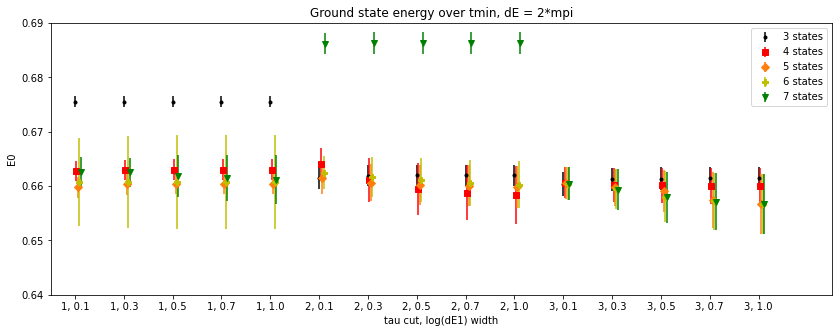

<Figure size 432x288 with 0 Axes>

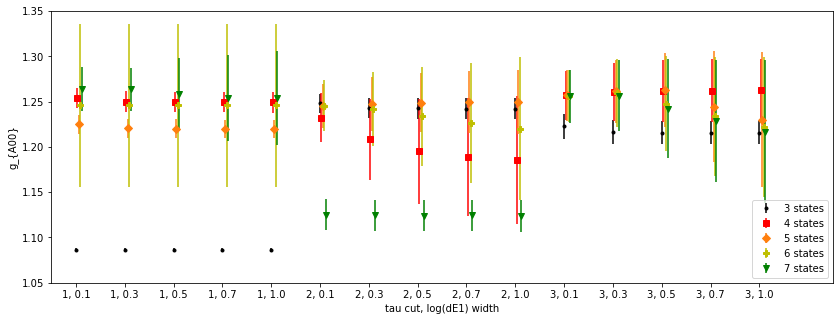

<Figure size 432x288 with 0 Axes>

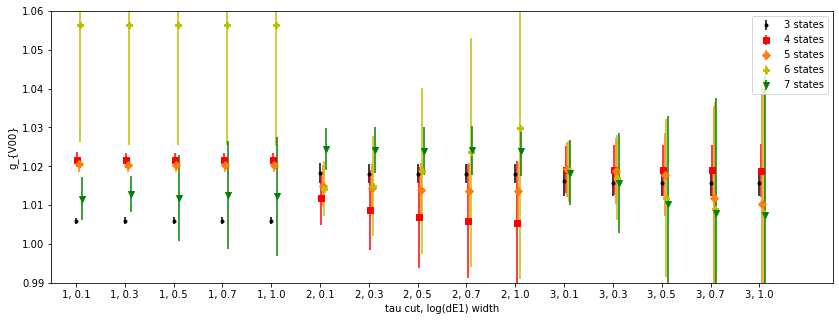

<Figure size 432x288 with 0 Axes>

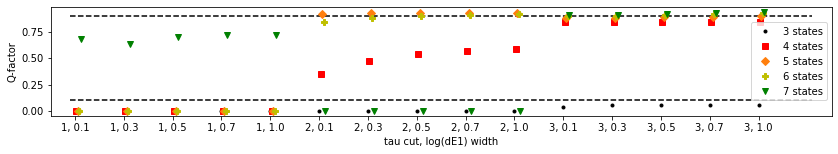

<Figure size 432x288 with 0 Axes>

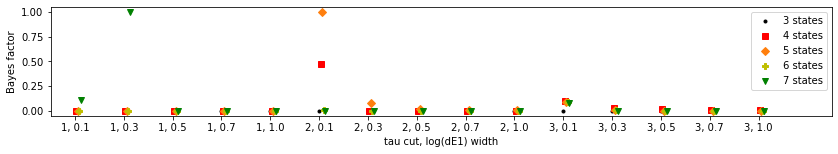

<Figure size 432x288 with 0 Axes>

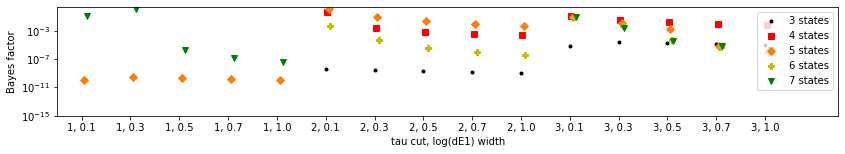

In [82]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c'])
ax_labels = np.array(["3 states", "4 states", "5 states", "6 states", "7 states"])





# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.64, 0.69])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.savefig('E0_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([1.05, 1.35])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.savefig('gA00_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.99, 1.06])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.savefig('gV00_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.savefig('Q_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend()
plt.ylabel("Bayes factor")
plt.savefig('BF_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.savefig('logBF_2pt3ptchained_samplecomparison_dEconst.png')
plt.show()

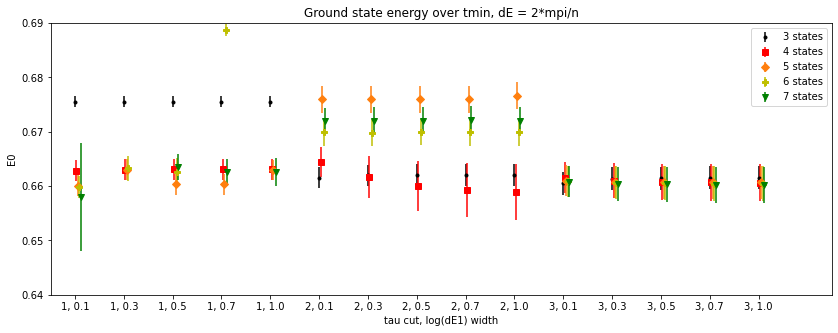

<Figure size 432x288 with 0 Axes>

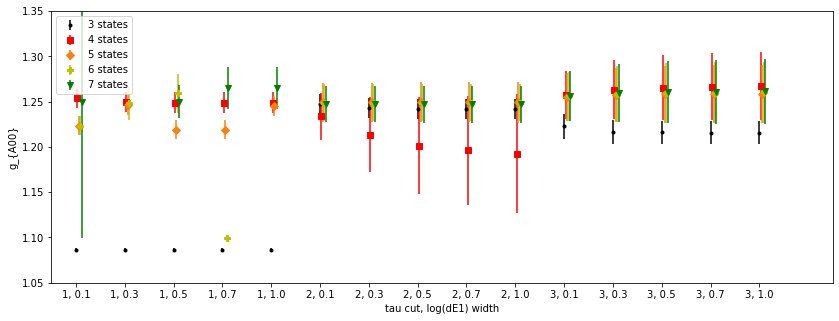

<Figure size 432x288 with 0 Axes>

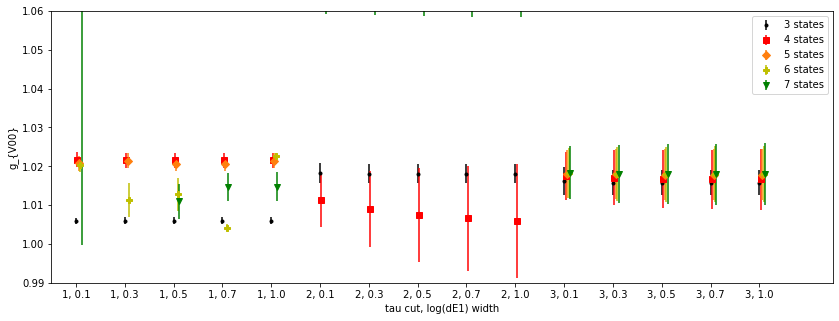

<Figure size 432x288 with 0 Axes>

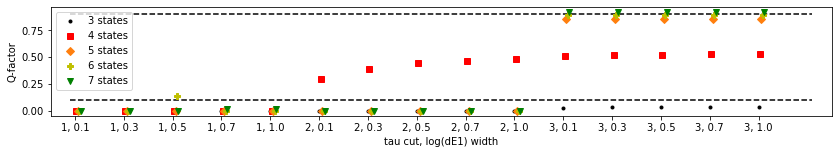

<Figure size 432x288 with 0 Axes>

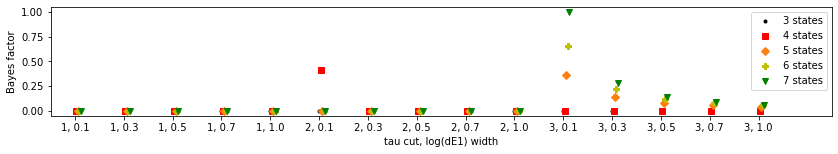

<Figure size 432x288 with 0 Axes>

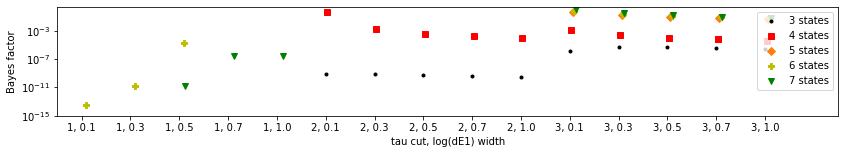

In [83]:
# Now, 1/n
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.64, 0.69])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.savefig('E0_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([1.05, 1.35])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.savefig('gA00_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.99, 1.06])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.savefig('gV00_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.savefig('Q_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend()
plt.ylabel("Bayes factor")
plt.savefig('BF_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.savefig('logBF_2pt3ptchained_samplecomparison_dE1overn.png')
plt.show()

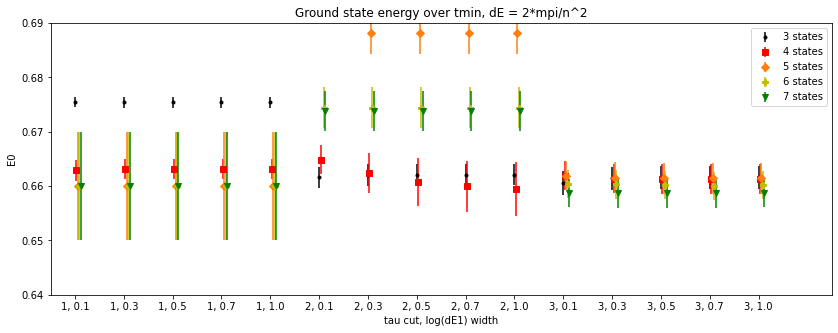

<Figure size 432x288 with 0 Axes>

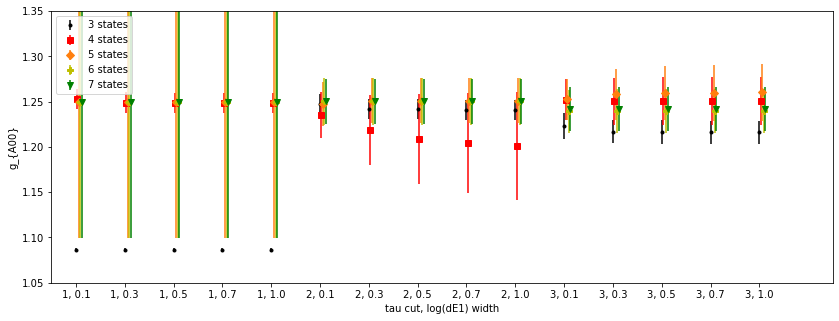

<Figure size 432x288 with 0 Axes>

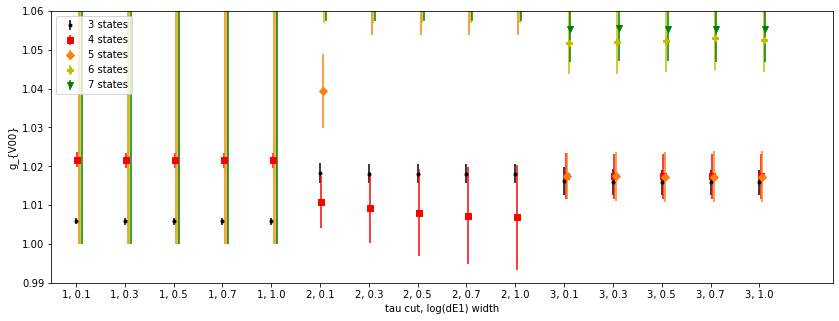

<Figure size 432x288 with 0 Axes>

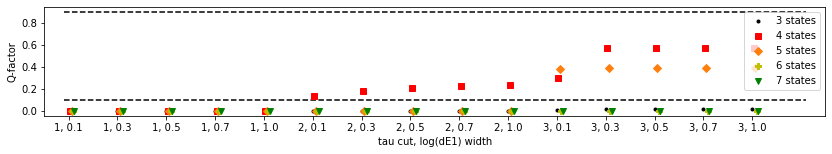

<Figure size 432x288 with 0 Axes>

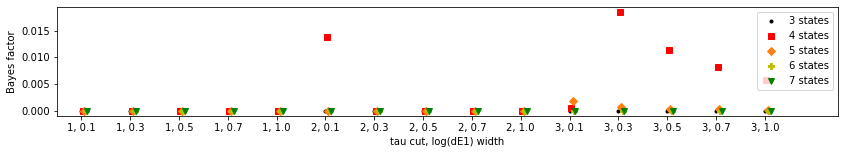

<Figure size 432x288 with 0 Axes>

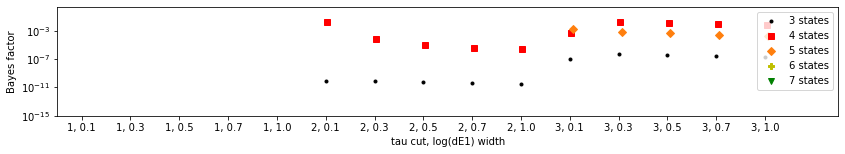

In [84]:
# Now, 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.64, 0.69])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")
plt.savefig('E0_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([1.05, 1.35])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.savefig('gA00_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.ylim([0.99, 1.06])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.savefig('gV00_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor")
plt.savefig('Q_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.savefig('BF_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.savefig('logBF_2pt3ptchained_samplecomparison_dE1overn2.png')
plt.show()